### Setup

In [2]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from matplotlib.gridspec import GridSpec

In [3]:
# global settings for pandas.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format = '{:.2f}'.format

# global settings for seaborn.
# sns.set_theme(style="whitegrid")
plt.style.use('seaborn')

### Funciones auxiliares

In [4]:
def describe_df(cols: list, df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un índice {cols} y un DataFrame {df}, devuelve otro DataFrame con datos descriptivos
    según las medidas especificadas en el diccionario {measures}.
    """
    measures = {
        'Cardinality': df.nunique(), 
        'Null': df.shape[0] - df.count(), 
        '% Null': round((df.shape[0] - df.count()) / df.shape[0] * 100, 3),
        'Non-Null': df.count(), 
        '% Non-Null': round(df.count() / df.shape[0] * 100, 3), 
        'Types': df.dtypes,
        'Size (mb)': df.memory_usage() / 1000000
    }    
    return pd.DataFrame(index=cols, data=measures)

### Índice

[### Funciones auxiliares]

### Carga inicial de datos

In [5]:
o_data = pd.read_csv(filepath_or_buffer='properati.csv')

### Descripción del juego de datos original

Se utiliza la función `describe_df` que toma a una `list` de columnas y a un `DataFrame` como argumentos y devuelve un dataframe con algunas descripciones sobre los datos.

Esto permite conocer la cantidad de valores unívocos por columna, el peso de los nulos y sus tipos de dato correspondientes.

In [6]:
o_describe = describe_df(cols=o_data.columns, df=o_data)
o_describe

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
Unnamed: 0,121220,0,0.00,121220,100.00,int64,0.97
operation,1,0,0.00,121220,100.00,object,0.97
property_type,4,0,0.00,121220,100.00,object,0.97
place_name,1060,23,0.02,121197,99.98,object,0.97
place_with_parent_names,1164,0,0.00,121220,100.00,object,0.97
country_name,1,0,0.00,121220,100.00,object,0.97
state_name,28,0,0.00,121220,100.00,object,0.97
geonames_id,646,18717,15.44,102503,84.56,float64,0.97
lat-lon,47203,51550,42.53,69670,57.47,object,0.97
lat,46495,51550,42.53,69670,57.47,float64,0.97


### Análisis de duplicados

El conjunto de datos, publicaciones de propiedades, corresponde al resultado de la ejecución de un web scrape o de un extracto de la base de datos de Properati. 

Siguiendo esta línea, el campo `properati_url` identifica a cada publicación y la presencia de valores duplicados en este campo, sería el indicador más claro de duplicidad.

Utilizando el método `duplicated` sobre el `DataFrame` e indicando como `subset` a la columna `properati_url` se puede evaluar lo anterior. 

In [7]:
o_data.duplicated(subset=['properati_url']).sum()

0

In [8]:
describe_df(o_data.columns, o_data).loc['properati_url']

Cardinality    121220
Null                0
% Null           0.00
Non-Null       121220
% Non-Null     100.00
Types          object
Size (mb)        0.97
Name: properati_url, dtype: object

No existen publicaciones duplicadas utilizando como identificador al vínculo de la publicación `properati_url` en la página de Properati.

### Análisis de dimensionalidad

Se evalúa removerer columnas que, a priori, no agregan valor para el análisis:

- **'Unnamed: 0'**: parece corresponder a un índice numérico.
- **'operation'**: se repite el mismo valor `sell` en todas las filas.
- **'place_with_parent_names'**: es una cadena de texto que concatena 'country_name', 'state_name' y 'place_name'.
- **'country_name'**: se repite el mismo valor `Argentina` en todas las filas.
- **'geonames_id'**: se debe buscar más información sobre este campo.
- **'lat-lon'**: se debe buscar más información sobre este campo.
- **'properati_url'**: vínculo a la publicación desde la que se obtuvieron y/o corresponden los datos.
- **'description'**: texto con datos adicionales sobre la publicación.
- **'title'**: título de la publicación.
- **'image_thumbnail'**: vínculo a la imagen miniatura de la publicación.

No obstante, para llegar a las conclusiones anteriores, las preguntas a responder fueron las siguientes:

- ¿Es el campo 'Unnamed: 0' simplemente una columna con un valor secuencial?
- ¿Es el campo 'operation' es relevante?
- ¿Es el campo 'place_with_parent_names' es relevante?
- ¿Es el campo 'country_name' es relevante?
- ¿Se pueden reducir los campos lat-lon, lat, lon y utilizar solo lat-lon?
- ¿Es el campo 'geonames_id' es relevante?
- ¿Existen datos adicionales dentro del título o de la descripción que sirvan para completar columnas faltantes?

#### Análisis de la variable: Unnamed: 0

##### ¿Es el campo 'Unnamed: 0' simplemente una columna con un valor secuencial?

In [9]:
describe_df(o_data.columns, o_data).loc['Unnamed: 0']

Cardinality    121220
Null                0
% Null           0.00
Non-Null       121220
% Non-Null     100.00
Types           int64
Size (mb)        0.97
Name: Unnamed: 0, dtype: object

In [10]:
o_data['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 121217, 121218, 121219], dtype=int64)

Si `Unnamed: 0` es un campo secuencial, sus elementos deberían ser iguales al `array` de `numpy` resultante de ejecutar el constructor `np.arange(0, total de filas)`.
El resultado de esto es un `array: Bool`.

In [11]:
o_data['Unnamed: 0'].values == np.arange(0, o_data.shape[0])

array([ True,  True,  True, ...,  True,  True,  True])

La suma de este array debe ser igual a la cantidad de filas en el `DataFrame` original, de esa manera, se puede concluir que el campo es un valor secuencial.

In [12]:
sum(o_data['Unnamed: 0'].values == np.arange(0, o_data.shape[0])) == o_data.shape[0]

True

#### Análisis de la variable: operation

##### ¿El campo 'operation' es relevante?

In [13]:
describe_df(o_data.columns, o_data).loc['operation']

Cardinality         1
Null                0
% Null           0.00
Non-Null       121220
% Non-Null     100.00
Types          object
Size (mb)        0.97
Name: operation, dtype: object

In [14]:
o_data['operation'].value_counts()

sell    121220
Name: operation, dtype: int64

El campo **operation** solamente repite el valor `sell` para cada observación.

#### Análisis de la variable: place_with_parent_names

##### ¿El campo 'place_with_parent_names' es relevante?

In [15]:
describe_df(o_data.columns, o_data).loc[['place_with_parent_names', 'country_name', 'state_name', 'place_name']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
place_with_parent_names,1164,0,0.00,121220,100.00,object,0.97
country_name,1,0,0.00,121220,100.00,object,0.97
state_name,28,0,0.00,121220,100.00,object,0.97
place_name,1060,23,0.02,121197,99.98,object,0.97


Se puede ver, a priori, que estos campos están completos en casi todos los registros. La única excepción es **place_name** que en solo 23 filas no hay datos.

Vale la pena analizar la hipótesis de si al concatenar **country_name**, **state_name** y **place_name** se puede llegar al mismo valor del campo **place_with_parent_names**.

Para esto, se visualizan los primeros valores de las columnas relevantes:

In [16]:
parent_names_subset = o_data[['place_with_parent_names', 'country_name', 'state_name', 'place_name']]
parent_names_subset.head(5)

,place_with_parent_names,country_name,state_name,place_name
0,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,Mataderos
1,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,La Plata
2,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,Mataderos
3,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,Liniers
4,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,Centro


Dado que el separador es el caracter '|', se concatenan los valores de **country_name**, **state_name** y **place_name** y luego se verifica que este valor sea igual al de la columna **place_with_parent_names**. Por último, se filtran las filas donde la expresión calculada y la columna no coincidan.

In [17]:
# expresión.
parent_names_subset['expression'] = '|' + parent_names_subset.iloc[:,1] + '|' + parent_names_subset.iloc[:,2] + '|' + parent_names_subset.iloc[:,3] + '|'
# expresión != place_with_parent_names
parent_names_subset.loc[(parent_names_subset['expression'] != parent_names_subset['place_with_parent_names'])].head()

,place_with_parent_names,country_name,state_name,place_name,expression
4,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,Centro,|Argentina|Buenos Aires Costa Atlántica|Centro|
6,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Argentina,Bs.As. G.B.A. Zona Norte,Munro,|Argentina|Bs.As. G.B.A. Zona Norte|Munro|
12,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|Martínez|
13,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,Palermo Soho,|Argentina|Capital Federal|Palermo Soho|
14,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,Palermo Soho,|Argentina|Capital Federal|Palermo Soho|


In [18]:
parent_names_subset.loc[(parent_names_subset['expression'] != parent_names_subset['place_with_parent_names'])].shape

(45220, 5)

Las filas donde la expresión difiere de la columna son 45.220 y vemos que, en algunos casos, hay más atributos de la ubicación dentro del campo **place_with_parent_names** y en otros simplemente es distinto. 

Este contexto adicional podría ser útil para agregar más precisión de manera categórica a la ubicación, aunque también podría evaluarse si permite completar los 23 valores nulos del campo **place_name**.

In [19]:
o_data[o_data['place_name'].isnull()].iloc[:,3:5]

,place_name,place_with_parent_names
6489,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
10201,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
11451,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
14839,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
18622,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
21922,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
23664,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
24722,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
38856,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
45970,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||


Aparentemente, los 23 valores faltantes para el campo **place_name** podemos obtenerlos del tercer valor concatenado dentro del campo **place_with_parent_names**.

In [20]:
o_data['place_name'] = o_data.apply(lambda x: x['place_with_parent_names'].split('|')[2] if x['place_name'] in (np.nan, None) else x['place_name'], axis=1)

Luego del apply anterior, los valores faltantes fueron introducidos y ya no quedan nulos.

In [21]:
describe_df(o_data.columns, o_data).loc[['place_with_parent_names', 'country_name', 'state_name', 'place_name']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
place_with_parent_names,1164,0,0.00,121220,100.00,object,0.97
country_name,1,0,0.00,121220,100.00,object,0.97
state_name,28,0,0.00,121220,100.00,object,0.97
place_name,1060,0,0.00,121220,100.00,object,0.97


#### Análisis de la variable: country_name

##### ¿Es relevante la variable country_name?

Luego de la función que cumplió el campo **country_name** en el paso anterior, la hipótesis es que su cardinalidad no aporta nada al análisis.

In [22]:
o_data['country_name'].value_counts()

Argentina    121220
Name: country_name, dtype: int64

In [23]:
describe_df(o_data.columns, o_data).loc['country_name']

Cardinality         1
Null                0
% Null           0.00
Non-Null       121220
% Non-Null     100.00
Types          object
Size (mb)        0.97
Name: country_name, dtype: object

Efectivamente, dado que solo tiene un valor y no registra nulos, podría ser excluido del juego de datos sin ningún impacto posterior.

#### Análisis de la variable: lat-lon

##### ¿Se puede reducir la cantidad de variables relacionadas: lat-lon, lat y lon?

La hipótesis es que el campo **lat-lon** puede reemplazar a los valores de los campos **lat** y **lon**, o bien, que ellos reemplacen al campo **lat-lon**.

El primer paso es crear un subset del DataFrame original con las columnas que nos interesan.

In [24]:
coordinates_subset = o_data[['lat-lon', 'lat', 'lon']]

Ahora evaluamos los siguientes escenarios:

- Cantidad de filas donde los valores de **lat-lon** son nulos y los valores de **lat** y **lon** también lo son (ie. `lat-long is null && lat is null & lon is null`)
  - Esto permitiría descartar a la columna **lat-lon** y trabajar con individualmente con sus componentes **lat** y **lon**.
- Coincidencia entre los valores en **lat-lon** y los valores en **lat** y **lon**.
  - Podría haber discrepancias entre estos campos o bien tener más precisión en alguno de ellos.

In [25]:
coordinates_mask = (coordinates_subset['lat-lon'].isnull()) & (coordinates_subset['lat'].isnull()) & (coordinates_subset['lon'].isnull())
describe_df(cols=coordinates_subset.columns, df=coordinates_subset.loc[coordinates_mask]).iloc[:,1:5]

,Null,% Null,Non-Null,% Non-Null
lat-lon,51550,100.00,0,0.00
lat,51550,100.00,0,0.00
lon,51550,100.00,0,0.00


In [26]:
describe_df(coordinates_subset.columns, coordinates_subset).iloc[:,1:5]

,Null,% Null,Non-Null,% Non-Null
lat-lon,51550,42.53,69670,57.47
lat,51550,42.53,69670,57.47
lon,51550,42.53,69670,57.47


Afortunadamente en todas las filas donde los valores de **lat-lon** son nulos, también lo son los valores de las columnas **lat** y **lon**.

Esto nos permitiría descartar a los valores de **lat-lon** siempre y cuando los mismos coincidan con aquellos que resultan de concatenar **lat** y **lon**.

A continuación probamos esta hipótesis, primero analizando la composición del campo conjunto de coordenadas y luego creando una expresión sintética para evaluar si son iguales:

In [27]:
coordinates_subset_not_null = coordinates_subset.loc[coordinates_subset['lat-lon'].isnull() == False]

In [28]:
coordinates_subset_not_null.head()

,lat-lon,lat,lon
0,"-34.6618237,-58.5088387",-34.66,-58.51
1,"-34.9038831,-57.9643295",-34.90,-57.96
2,"-34.6522615,-58.5229825",-34.65,-58.52
3,"-34.6477969,-58.5164244",-34.65,-58.52
4,"-38.0026256,-57.5494468",-38.00,-57.55


In [29]:
coordinates_subset_not_null.tail()

,lat-lon,lat,lon
121153,"-34.5992135511,-58.4025191971",-34.60,-58.40
121158,"-34.587425443,-58.3973722534",-34.59,-58.40
121160,"-34.563685346,-58.4426825896",-34.56,-58.44
121209,"-34.563685346,-58.4426825896",-34.56,-58.44
121217,"-34.5706388726,-58.4755963355",-34.57,-58.48


A priori se ve que los valores de **lat-lon** tienen algunos decimales más de precisión que los respectivos valores de los campos de **lat** y **lon**. Considerando una hipotética precisión adicional, podría ser útil reemplazar a los valores de los campos **lat** y **lon**.

Esto mismo se debe tener en cuenta al momento de hacer la comparación:

In [30]:
coordinates_subset_not_null['extracted_lat'] = coordinates_subset_not_null['lat-lon'].apply(lambda x: x.split(',')[0])
coordinates_subset_not_null['extracted_lon'] = coordinates_subset_not_null['lat-lon'].apply(lambda x: x.split(',')[1])

Comparamos hasta 3 decimales.

"The third decimal place is worth up to 110 m: it can identify a large agricultural field or institutional campus."

Source: https://stackoverflow.com/questions/1947481/how-many-significant-digits-should-i-store-in-my-database-for-a-gps-coordinate

In [31]:
coordinates_subset_not_null['extracted_lat'] = coordinates_subset_not_null['extracted_lat'].astype('float64')
coordinates_subset_not_null['extracted_lon'] = coordinates_subset_not_null['extracted_lon'].astype('float64')
coordinates_subset_not_null['lat'] = coordinates_subset_not_null['lat'].astype('float64')
coordinates_subset_not_null['lon'] = coordinates_subset_not_null['lon'].astype('float64')
coordinates_subset_not_null.shape

(69670, 5)

In [32]:
(coordinates_subset_not_null['extracted_lat'].apply(lambda x: round(x, 3)) == coordinates_subset_not_null['lat'].apply(lambda x: round(x, 3))).sum()

69670

In [33]:
(coordinates_subset_not_null['extracted_lon'].apply(lambda x: round(x, 3)) == coordinates_subset_not_null['lon'].apply(lambda x: round(x, 3))).sum()

69670

En el punto anterior logramos comprobar que los valores de los tres campos analizados coinciden entre sí hasta en un rango de 111 metros, en todos los casos.

Resulta una buena oportunidad apalancar la precisión adicional presente en el campo **lat-lon** para reemplazar a los valores existentes en **lat** y **lon** respectivamente.

Además, se podría desestimar el campo **lat-lon** ahora que fue desestructurado.

In [34]:
o_data['lat'] = o_data['lat-lon'].map(lambda x: x.split(',')[0] if isinstance(x, str) else np.nan)
o_data['lon'] = o_data['lat-lon'].map(lambda x: x.split(',')[1] if isinstance(x, str) else np.nan)
o_data['lat'] = o_data['lat'].astype('float64')
o_data['lon'] = o_data['lon'].astype('float64')
describe_df(o_data.columns, o_data).loc[['lat-lon', 'lon', 'lat']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
lat-lon,47203,51550,42.53,69670,57.47,object,0.97
lon,46522,51550,42.53,69670,57.47,float64,0.97
lat,46495,51550,42.53,69670,57.47,float64,0.97


#### Análisis de la variable: geonames_id

##### ¿Es relevante el campo geonames_id?

La hipótesis es que el campo **geonames_id** hace referencia a la base de datos: https://www.geonames.org/

En este caso, podría ser útil evaluar si existen casos donde **geonames_id** pueda complementar a las columnas de **lat** y **lon**.

El primer paso es crear un subset del DataFrame original con las columnas que nos interesan.

In [35]:
geo_subset = o_data[['geonames_id', 'lat', 'lon']]

Ahora evaluamos los siguientes escenarios:

- Cantidad de filas donde **geonames_id** no es nulo pero los campos **lat** y **lon** sí lo son.
  - Para las filas donde esto suceda, **geonames_id** podría utilizarse para completarlas.

In [36]:
geo_subset_null_mask = (geo_subset['geonames_id'].isnull() == False) & (geo_subset['lat'].isnull()) & (geo_subset['lon'].isnull())
geo_subset_null = geo_subset[geo_subset_null_mask]
describe_df(geo_subset_null.columns, geo_subset_null)

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
geonames_id,463,0,0.00,43365,100.00,float64,0.35
lat,0,43365,100.00,0,0.00,float64,0.35
lon,0,43365,100.00,0,0.00,float64,0.35


El hecho de que para cada fila donde los valores de **lat** y **lon** son nulos exista un valor de **geonames_id**, permite la posibilidad de completar, por lo menos, algunos de los valores faltantes.

Para esto descargamos el dataset de Argentina disponible en la siguiente URL: https://download.geonames.org/export/dump/

In [37]:
geonames_columns = ['geonames_id', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 'feature_code', 'country_code', 'cc2', 
                    'admin1_code', 'admin2_code', 'admin3_code', 'admin4 code', 'population', 'elevation', 'dem', 'timezone', 'modification date']

geonames_df = pd.read_csv('AR.txt', delimiter='\t', names=geonames_columns)
geonames_df.set_index('geonames_id', inplace=True)
geonames_df.head()

,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4 code,population,elevation,dem,timezone,modification date
geonames_id,,,,,,,,,,,,,,,,,,
3427200,Sierra del 15,Sierra del 15,NaN,-37.97,-57.95,T,HLL,AR,NaN,1.00,6357.00,nan,nan,0,nan,200,America/Argentina/Buenos_Aires,2016-01-30
3427201,Puesto 1 Napoleón Cué,Puesto 1 Napoleon Cue,NaN,-28.63,-56.12,S,HSE,AR,NaN,6.00,18168.00,nan,nan,0,nan,79,America/Argentina/Cordoba,2016-01-30
3427202,Cañada del Zorro,Canada del Zorro,NaN,-32.17,-59.50,H,STM,AR,NaN,8.00,nan,nan,nan,0,nan,65,America/Argentina/Cordoba,1993-12-21
3427203,Estancia Zorraquín,Estancia Zorraquin,NaN,-31.52,-58.55,S,RNCH,AR,NaN,8.00,30113.00,nan,nan,0,nan,71,America/Argentina/Cordoba,2016-01-30
3427204,Estancia Zequeira Cué,Estancia Zequeira Cue,NaN,-28.44,-56.09,S,RNCH,AR,NaN,6.00,18168.00,nan,nan,0,nan,98,America/Argentina/Cordoba,2016-01-30


Una vez cargado el conjunto de datos anterior, el paso siguiente es determinar los valores unívocos de **geonames_id** y hacer el mapeo de las columnas **lat** y **lon**.

In [38]:
geonames_lat_mapping_dict = { geo_id: geonames_df.loc[int(geo_id)].loc['latitude'] for geo_id in geo_subset_null['geonames_id'].unique() if geo_id in geonames_df.index }
geonames_lon_mapping_dict = { geo_id: geonames_df.loc[int(geo_id)].loc['longitude'] for geo_id in geo_subset_null['geonames_id'].unique() if geo_id in geonames_df.index }

In [39]:
o_data['lat'] = o_data.apply(lambda x: geonames_lat_mapping_dict.get(x['geonames_id'], np.nan) if np.isnan(x['lat']) else x['lat'], axis=1)
o_data['lon'] = o_data.apply(lambda x: geonames_lon_mapping_dict.get(x['geonames_id'], np.nan) if np.isnan(x['lon']) else x['lon'], axis=1)

Se logró incrementar la cantidad de filas con valores no nulos para las columnas **lat** y **lon** hasta el 93.115% del total.

In [40]:
describe_df(o_data.columns, o_data).loc[['lat', 'lon']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
lat,46918,8346,6.88,112874,93.11,float64,0.97
lon,46942,8346,6.88,112874,93.11,float64,0.97


Existen otras dos alternativas para llevar el porcentaje de nulos a un valor todavía más bajo:
* utilizar el valor de la columna **place_name** para buscar una latitud y longitud dentro del DataFrame `geonames_df`.

* utilizar el valor de la columna **place_name** para buscar latitudes y longitudes ya existentes dentro del DataFrame original.

Si bien la primera alternativa parece ideal, no es tan exacta como se puede ver a continuación dado que existen varias ubicaciones con un mismo nombre pero en distintas provincias:

In [41]:
geonames_df.loc[ geonames_df['name'] == 'Pilar' ]

,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4 code,population,elevation,dem,timezone,modification date
geonames_id,,,,,,,,,,,,,,,,,,
3429980,Pilar,Pilar,Pilar,-34.46,-58.91,P,PPLA2,AR,NaN,1.00,6638.00,nan,nan,226517,nan,27,America/Argentina/Buenos_Aires,2017-12-21
3480748,Pilar,Pilar,NaN,-34.44,-58.91,L,LCTY,AR,NaN,1.00,nan,nan,nan,0,nan,18,America/Argentina/Buenos_Aires,2013-08-08
3841149,Pilar,Pilar,Pilar,-31.68,-63.88,P,PPL,AR,NaN,5.00,14119.00,nan,nan,12488,nan,334,America/Argentina/Cordoba,2016-01-30
3841150,Pilar,Pilar,NaN,-31.44,-61.26,P,PPL,AR,NaN,21.00,82070.00,nan,nan,0,nan,62,America/Argentina/Cordoba,2016-01-30


La otra alternativa tiene menos margen de error dado que podemos acotar los aciertos entre provincias utilizando el campo **state_name**.

El primer paso es armar un subconjunto de valores con menos registros para agilizar la búsqueda:

In [42]:
missing_coordinates_places = o_data[o_data['lat'].isnull()]['place_name'].unique()
missing_coordinates_states = o_data[o_data['lat'].isnull()]['state_name'].unique()
lookup_subset = o_data.loc[ (o_data['state_name'].isin(missing_coordinates_states)) & (o_data['place_name'].isin(missing_coordinates_places)) & (o_data['lat'].isnull() == False) ]
lookup_subset['place_id'] = lookup_subset['state_name'] + '-' + lookup_subset['place_name']
lookup_subset = lookup_subset[['place_id', 'lat', 'lon']]
lookup_subset = lookup_subset.drop_duplicates(subset='place_id')
lookup_subset.set_index('place_id', inplace=True)
lookup_subset.head(5)

,lat,lon
place_id,,
Buenos Aires Costa Atlántica-Centro,-38.00,-57.55
Bs.As. G.B.A. Zona Norte-San Miguel,-34.54,-58.72
Bs.As. G.B.A. Zona Norte-Tigre,-34.43,-58.58
Bs.As. G.B.A. Zona Norte-Estancias del Pilar,-34.48,-58.98
Bs.As. G.B.A. Zona Norte-Pilar,-34.45,-58.84


Definimos una función que dado un valor de fila, busque en el DataFrame `lookup_subset` la coordenada correspondiente: 

In [43]:
def get_coordinate(row: pd.Series, coordinate: str) -> str:
    place_id = f"{row['state_name']}-{row['place_name']}"
    if np.isnan(row[coordinate]) and place_id in lookup_subset.index:
        return lookup_subset.loc[place_id][coordinate]
    return row[coordinate]

In [44]:
o_data['lat'] = o_data.apply(get_coordinate, args=['lat'], axis=1)
o_data['lon'] = o_data.apply(get_coordinate, args=['lon'], axis=1)

In [45]:
describe_df(o_data.columns, o_data).loc[['lat', 'lon']]

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
lat,46918,60,0.05,121160,99.95,float64,0.97
lon,46942,60,0.05,121160,99.95,float64,0.97


In [46]:
o_data[o_data['lat'].isnull()]['state_name'].unique()

array(['Buenos Aires Costa Atlántica', 'Buenos Aires Interior',
       'Catamarca', 'Santa Fe', 'Córdoba', 'Entre Ríos',
       'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur'], dtype=object)

Gracias al proceso anterior se logró reducir la cantidad de registros nulos a solo 60 ocurrencias!

#### Análisis de la variable: rooms

La cantidad de ambientes, representada por el campo *rooms*, es crítica para darle contexto al precio de la propiedad. Por ende, se debe hacer el mayor esfuerzo posible para:
- recuperar la mayor cantidad de los valores faltantes.
- verificar que los valores existentes estén correctos.

Las alternativas para completar los valores faltantes son tres:
- búsqueda dentro de los valores de la columna **title**.
- búsqueda dentro de los valores de la columna **description**.
- búsqueda dentro de los valores de la columna **properati_url**.


In [47]:
describe_df(o_data.columns, o_data).loc['rooms']

Cardinality         31
Null             73830
% Null           60.91
Non-Null         47390
% Non-Null       39.09
Types          float64
Size (mb)         0.97
Name: rooms, dtype: object

El DataFrame original tiene casi 61% de valores nulos.

El primer intento está en la búsqueda de los valores faltantes dentro del campo **description**. 

Para esto se convierte el campo a texto, y se emplea una función personalizada para extraer vía `regex` los valores faltantes.

In [48]:
o_data["description"] = o_data["description"].astype(str)

La estrategia para obtener la cantidad de ambientes se basa en adoptar distintos regex pequeños, ordenados por prioridad en función a su precisión, sobre los campos **description** y **titles**.

La función `parse_rooms` toma a la fila del `DataFrame` como argumento, junto a la columna sobre la cual aplicar el regex y la columna con el valor buscado para evitar reemplazos sobre datos ya existentes. Además, incorpora la posibilidad de aplicar de manera recursiva la función sobre otro campo del `DataFrame` si en el primer lugar no hubieron aciertos. 

In [49]:
# patrón general.
pat_rooms_a = '(?i)((?P<u>((mono)|(1)))|(?P<d>dos)|(?P<t>tres)|(?P<c>cuatro)|(?P<ci>cinco)|(?P<s>seis)|(?P<si>siete)|(?P<o>ocho)|(?P<n>nueve))\s?((amb)|(dor))'
reg_rooms_a = re.compile(pat_rooms_a)

def rooms_a(x):
    
    match = reg_rooms_a.search(x)
    
    if match is not None:
        group = match.group('u','d','t','c','ci','s','si','o','n')        
        for i in range(len(group)):            
            if group[i] is None:
                continue
            else:
                return float(i+1)
        return None

def parse_rooms(row, parse_from_column, parsed_column, recursive = False):
    
    if not np.isnan(row[parsed_column]):
        return row[parsed_column]
    
    lower_text = row[parse_from_column].lower()
    
    # regex
    regex_0 = re.search(r'((monoamb|monoambiente))', lower_text) # 'monoamb'
    regex_1 = re.search(r'(\d+)(\s)(\b(amb))', lower_text) # '2 amb'
    regex_2 = re.search(r'((\b(amb))(\D)(\d+))', lower_text) # ' amb:2'
    regex_3 = re.search(r'(\d+)((amb)\b)', lower_text) # ' 3amb'
    regex_4 = re.search(r'(\b(dos))(\s)(\b(amb))', lower_text) # 'dos ambientes'
    regex_5 = re.search(r'(\b(tres))(\s)(\b(amb))', lower_text) # 'tres ambientes'
    regex_6 = re.search(r'(\b(cuatro))(\s)(\b(amb))', lower_text) # 'cuatro ambientes'
    regex_7 = re.search(r'(\b(cinco))(\s)(\b(amb))', lower_text) # 'cinco ambientes'
    regex_8 = re.search(r'(\b(seis))(\s)(\b(amb))', lower_text) # 'seis ambientes'
    regex_9 = re.search(r'(\b(siete))(\s)(\b(amb))', lower_text) # 'siete ambientes'
    
    parse_digits = lambda x: re.search(r'(\d+)', x)
    
    if regex_0:
        return 1
    
    if regex_1:
        result = parse_digits(regex_1.group(1))
        if result:
            return int(result.group(1))
        
    if regex_2:
        result = parse_digits(regex_2.group(1))
        if result:
            return int(result.group(1))
        
    if regex_3:
        result = parse_digits(regex_3.group(1))
        if result:
            return int(result.group(1))
    
    if regex_4:
        return 2
    
    if regex_5:
        return 3
    
    if regex_6:
        return 4
    
    if regex_7:
        return 5
    
    if regex_8:
        return 6
    
    if regex_9:
        return 7
    
    result = rooms_a(lower_text)
    if result:
        return result
    
    # recursive call - parsing title.
    if not recursive:
        return parse_rooms(row, 'title', 'rooms', True)
        
    return result if result is not None else np.nan


In [50]:
describe_df(o_data.columns, o_data).loc['rooms']

Cardinality         31
Null             73830
% Null           60.91
Non-Null         47390
% Non-Null       39.09
Types          float64
Size (mb)         0.97
Name: rooms, dtype: object

In [51]:
o_data['rooms'] = o_data.apply(parse_rooms, args=['description', 'rooms'], axis=1)

In [52]:
describe_df(o_data.columns, o_data).loc['rooms']

Cardinality         73
Null             32912
% Null           27.15
Non-Null         88308
% Non-Null       72.85
Types          float64
Size (mb)         0.97
Name: rooms, dtype: object

Se lograron completar 40.918 valores nulos mediante la aplicación de la función `parse_rooms`.

#### Análisis de la variables: surface_covered_in_m2 & surface_total_in_m2

Al igual que los casos anteriores de **rooms** y **precio_aprox_usd**, estos campos son críticos a los fines de explicar el precio. Por ende, se debe hacer el mayor esfuerzo posible para:
- recuperar la mayor cantidad de los valores faltantes.
- verificar que los valores existentes estén correctos.

Las alternativas para completar los valores faltantes son tres:
- búsqueda dentro de los valores de la columna **title**.
- búsqueda dentro de los valores de la columna **description**.
- búsqueda dentro de los valores de la columna **properati_url**.


En primer lugar se trata el campo **surface_covered_in_m2** y para rellenar los nulos se aplica una función personalizada que intenta, mediante varios `regex` y recursión, obtener los precios desde los campos **description** y **title**, en ese orden de prioridad.

In [53]:
# regex
pat_covered_1 = re.compile('cub(iertos?)?:?\s?(?P<m2>\.?\d+)\s?(cub(iertos?))?')
pat_covered_2 = re.compile('(cub(iertos?)?:?\s?)?(?P<m2>(\.?\d)+)\s?[Mm][Tt]?[Ss]?[2²]?(cub(iertos?))?')
pat_covered_3 = re.compile('(edi(ficados?)?:?\s?)?(?P<m2>(\.?\d)+)\s?[Mm][Tt]?[Ss]?[2²]?(edi(ficados?))?')
pat_covered_4 = re.compile('(edificados?:?\s?)?(?P<m2>(\.?\d)+)\s?[Mm][Tt]?[Ss]?[2²]?\s?(edificados?)?')

def parse_covered_surface(row, parse_from_column, parsed_column, recursive = False):
    
    if not np.isnan(row[parsed_column]):
        return row[parsed_column]
    
    lower_text = row[parse_from_column].lower()
    
    # regex
    pat_covered_01 = re.search(pat_covered_1, lower_text) # 
    pat_covered_02 = re.search(pat_covered_2, lower_text) # 
    pat_covered_03 = re.search(pat_covered_3, lower_text) # 
    pat_covered_04 = re.search(pat_covered_4, lower_text) # 
    
    parse_digits = lambda x: re.sub('\,|\s','.', x)
        
    if pat_covered_01:
        result = parse_digits(pat_covered_01.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
    
    if pat_covered_02:
        result = parse_digits(pat_covered_02.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
    
    if pat_covered_03:
        result = parse_digits(pat_covered_03.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
    
    if pat_covered_04:
        result = parse_digits(pat_covered_04.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
            
    # recursive call - parsing title.
    if not recursive:
        return parse_covered_surface(row, 'title', parsed_column, True)
        
    return np.nan


In [54]:
describe_df(o_data.columns, o_data).loc['surface_covered_in_m2']

Cardinality        995
Null             19907
% Null           16.42
Non-Null        101313
% Non-Null       83.58
Types          float64
Size (mb)         0.97
Name: surface_covered_in_m2, dtype: object

In [55]:
o_data['surface_covered_in_m2'] = o_data.apply(parse_covered_surface, args=['description', 'surface_covered_in_m2', False], axis=1)

In [56]:
describe_df(o_data.columns, o_data).loc['surface_covered_in_m2']

Cardinality       1436
Null             12542
% Null           10.35
Non-Null        108678
% Non-Null       89.65
Types          float64
Size (mb)         0.97
Name: surface_covered_in_m2, dtype: object

Se lograron completar 7.365 filas que tenían valores nulos a partir de la aplicación del `regex` mediante la función `parse_covered_surface`.

En segundo lugar se trata el campo **surface_total_in_m2** y para rellenar los nulos se aplica una función personalizada que intenta, mediante varios `regex` y recursión, obtener los precios desde los campos **description** y **title**, en ese orden de prioridad.

In [57]:
pat_m2_1 = re.compile('(?i)(tot(al(es)?)?)?:?\s?(?P<m2>(\.?\d)+)\s?[Mm][Tt]?[Ss]?[2²]?\s?(tot(al(es)?)?)?')
pat_m2_2 = re.compile('(?P<m2>(\.?\d)+)\s?[Mm][Tt]?[Ss]?[2²]?')
pat_m2_3 = re.compile('(?i)(?P<m2>\.?\d+)\s?(metros)')

def parse_total_surface(row, parse_from_column, parsed_column, recursive = False):
    
    if not np.isnan(row[parsed_column]):
        return row[parsed_column]
    
    lower_text = row[parse_from_column].lower()
        
    # regex
    pat_m2_01 = re.search(pat_m2_1, lower_text) # 
    pat_m2_02 = re.search(pat_m2_2, lower_text) #
    pat_m2_03 = re.search(pat_m2_3, lower_text) # 
    
    parse_digits = lambda x: re.sub('\,|\s','.', x)
        
    if pat_m2_01:
        result = parse_digits(pat_m2_01.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
        
    if pat_m2_02:        
        result = parse_digits(pat_m2_02.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
        
    if pat_m2_03:        
        result = parse_digits(pat_m2_03.group('m2'))
        try:
            return float(result)
        except ValueError:
            pass
        
    # recursive call - parsing title.
    if not recursive:
        return parse_total_surface(row, 'title', parsed_column, True)
        
    return np.nan


In [58]:
describe_df(o_data.columns, o_data).loc['surface_total_in_m2']

Cardinality       1687
Null             39328
% Null           32.44
Non-Null         81892
% Non-Null       67.56
Types          float64
Size (mb)         0.97
Name: surface_total_in_m2, dtype: object

In [59]:
o_data['surface_total_in_m2'] = o_data.apply(parse_covered_surface, args=['description', 'surface_total_in_m2', False], axis=1)

In [60]:
describe_df(o_data.columns, o_data).loc['surface_total_in_m2']

Cardinality       2398
Null             23501
% Null           19.39
Non-Null         97719
% Non-Null       80.61
Types          float64
Size (mb)         0.97
Name: surface_total_in_m2, dtype: object

Se completaron 15.791 filas que antes tenían valores nulos.

Reemplazamos los valores nulos entre las columnas de superficie total y cubierta, en los casos donde sea posible.

In [61]:
o_data['surface_covered_in_m2'] = o_data.apply(lambda x: x.surface_total_in_m2 if np.isnan(x.surface_covered_in_m2) and not np.isnan(x.surface_total_in_m2) else x.surface_covered_in_m2, axis=1)  
o_data['surface_total_in_m2'] = o_data.apply(lambda x: x.surface_covered_in_m2 if np.isnan(x.surface_total_in_m2) and not np.isnan(x.surface_covered_in_m2) else x.surface_total_in_m2, axis=1)  

A su vez, tampoco pueden existir casos donde la superficie cubierta sea mayor a la superficie total. Para esto, se aplica una función que aplique esta restricción sobre el campo **surface_total_in_m2**.

In [62]:
def check_total_surface(row):
    if np.isnan(row.surface_covered_in_m2) or np.isnan(row.surface_total_in_m2):
        return row.surface_total_in_m2
    if row.surface_covered_in_m2 > row.surface_total_in_m2:
        return row.surface_covered_in_m2
    return row.surface_total_in_m2

o_data['surface_total_in_m2'] = o_data.apply(check_total_surface, axis=1)

#### Análisis de la variable: price_aprox_usd

El precio de la propiedad, representada por el campo *price_usd*, es un valor crítico para calibrar de manera posterior al modelo. Por ende, se debe hacer el mayor esfuerzo posible para:
- recuperar la mayor cantidad de los valores faltantes.
- verificar que los valores existentes estén correctos.

Las alternativas para completar los valores faltantes son tres:
- búsqueda dentro de los valores de la columna **title**.
- búsqueda dentro de los valores de la columna **description**.
- búsqueda dentro de los valores de la columna **properati_url**.

Debido a que en la dinámica del mercado inmobiliario se estila realizar las operaciones en USD, se toma como moneda de referencia al campo en dólares.

La estrategia a aplicar para rellenar los nulos es mediante `regex` obtener los precios desde los campos **description** y **title**, en ese orden de prioridad.

In [63]:
# regex
pat_uss_compiled = re.compile('(?P<dolar>[Uu][S\$s][Ss\$])\s?(?P<precio>(\.?\d+)+)') # 'uss u$s us$ 1000'
pat_usd_compiled = re.compile('(?P<dolar>[Uu][Ss][Dd])\s?(?P<precio>(\.?\d+)+)') # 'usd USD 1000'
pat_uss_compiled_inv = re.compile('(?P<precio>(\.?\d+)+)\s?(?P<dolar>[Uu][S\$s][Ss\$])') # 1000 uss u$s us$
pat_usd_compiled_inv = re.compile('(?P<precio>(\.?\d+)+)\s?(?P<dolar>[Uu][Ss][Dd])') # 1000 usd USD

def parse_price(row, parse_from_column, parsed_column, recursive = False):
    
    if not np.isnan(row[parsed_column]):
        return row[parsed_column]
    
    lower_text = row[parse_from_column].lower()
    
    # reemplaza otras expresiones de dólares a valores esperados.
    lower_text = lower_text.replace('dólares', 'usd')
    lower_text = lower_text.replace('dolares', 'usd')
    
    # regex
    pat_uss = re.search(pat_uss_compiled, lower_text) # 'uss u$s us$ 1000'
    pat_usd = re.search(pat_usd_compiled, lower_text) # 'usd USD 1000'
    pat_uss_inv = re.search(pat_uss_compiled_inv, lower_text) # 1000 uss u$s us$
    pat_usd_inv = re.search(pat_usd_compiled_inv, lower_text) # 1000 usd USD    
    
    parse_digits = lambda x: re.sub('\.|\s','', x)
        
    if pat_uss:
        result = parse_digits(pat_uss.group('precio'))
        try:
            return float(result)
        except ValueError:
            pass
        
    if pat_usd:        
        result = parse_digits(pat_usd.group('precio'))
        try:
            return float(result)
        except ValueError:
            pass
        
    if pat_uss_inv:        
        result = parse_digits(pat_uss_inv.group('precio'))
        try:
            return float(result)
        except ValueError:
            pass
        
    if pat_usd_inv:
        result = parse_digits(pat_usd_inv.group('precio'))
        try:
            return float(result)
        except ValueError:
            pass
    
    # recursive call - parsing title.
    if not recursive:
        return parse_price(row, 'title', parsed_column, True)
        
    return np.nan


In [64]:
describe_df(o_data.columns, o_data).loc['price_aprox_usd']

Cardinality      10364
Null             20410
% Null           16.84
Non-Null        100810
% Non-Null       83.16
Types          float64
Size (mb)         0.97
Name: price_aprox_usd, dtype: object

In [65]:
o_data['price_aprox_usd'] = o_data.apply(parse_price, args=['description', 'price_aprox_usd', False], axis=1)

In [66]:
describe_df(o_data.columns, o_data).loc['price_aprox_usd']

Cardinality      10470
Null             19279
% Null           15.90
Non-Null        101941
% Non-Null       84.10
Types          float64
Size (mb)         0.97
Name: price_aprox_usd, dtype: object

Se reemplazaron 1.131 filas que estaban con el valor nulo.

#### Análisis de la variable: **price_usd_per_m2**

A su vez, también es posible calcular el valor de precio en dólares del metro cuadrado representado por la columna **price_usd_per_m2**.

Para esto se aplica una función personalizada que:
- no reemplaza los valores no nulos existentes del campo.
- devuelve el valor de **price_per_m2** si la moneda de la fila es USD.
- devuelve la división entre el **price_aprox_usd** y **surface_total_in_m2**

In [67]:
def calculate_price_usd_per_m2(row):
    if not np.isnan(row.price_usd_per_m2):
        return row.price_usd_per_m2
    if not np.isnan(row.price_per_m2) and row.currency == 'USD':
        return row.price_per_m2
    if np.isnan(row.price_aprox_usd) or np.isnan(row.surface_total_in_m2):
        return row.price_usd_per_m2
    if row.surface_total_in_m2 <= 0:
        return row.price_usd_per_m2
    
    return row.price_aprox_usd / row.surface_total_in_m2


In [68]:
describe_df(o_data.columns, o_data).loc['price_usd_per_m2']

Cardinality      25567
Null             52603
% Null           43.40
Non-Null         68617
% Non-Null       56.60
Types          float64
Size (mb)         0.97
Name: price_usd_per_m2, dtype: object

In [69]:
o_data['price_usd_per_m2'] = o_data.apply(calculate_price_usd_per_m2, axis=1)

In [70]:
describe_df(o_data.columns, o_data).loc['price_usd_per_m2']

Cardinality      32426
Null             24967
% Null           20.60
Non-Null         96253
% Non-Null       79.40
Types          float64
Size (mb)         0.97
Name: price_usd_per_m2, dtype: object

Se lograron completar XX filas que tenían el valor nulo mediante esta técnica anterior.

### Análisis de outliers

Para el análisis y filtrado de los *outliers*, se definió aplicar un critero mixtro entre los valores de los rangos intercuartil y el sentido común para la métrica que se filtra. 

Se debe tener particular cuidado en explorar la distribución no solo del conjunto entero, sino de los subconjuntos que forman los distintos valores del campo **property_type**.

Para esto se crearon las funciones `histogram_plot_by_property_type` y `box_plot_by_property_type`.

In [71]:
def histogram_plot_by_property_type(fig, df, column, non_na_bins = False, unique_bins = True):
    
    by_column = 'property_type'
    property_types = ['PH', 'apartment', 'house', 'store', 'Dummy']
    colors = ["#98ce00","#16e0bd","#78c3fb","#89a6fb","#98838f"]
        
    for idx, ax in enumerate(fig.axes):        
                
        if idx == 4:
            subset = df[column]            
            description = subset.describe()
            has_nas = (~np.isnan(subset.unique())).sum() != len(subset.unique())
            bins = len(subset.unique()) - 1 if non_na_bins and has_nas else len(subset.unique())
            ax.hist(subset, bins=bins if unique_bins else None, color=colors[idx], alpha=0.7)
            ax.set_title('Todos')
        else:
            subset = df.loc[o_data[by_column] == property_types[idx]][column]
            description = subset.describe()
            has_nas = (~np.isnan(subset.unique())).sum() != len(subset.unique())
            bins = len(subset.unique()) - 1 if non_na_bins and has_nas else len(subset.unique())
            ax.hist(subset, bins=bins if unique_bins else None, color=colors[idx], alpha=0.7)
            ax.set_title(property_types[idx])
            
        # axis styling.
        ax.tick_params(labelbottom=True, labelleft=True)            
        ax.set_xlabel(f"count: {round(description.loc['count'])} - mean: {round(description.loc['mean'],2)} - std: {round(description.loc['std'],2)} - max: {round(description.loc['max'],2)}")
        ax.axvline(x=description.loc['mean'], color='green')
        ax.axvline(x=description.loc['mean'] + (description.loc['std'] * 3), color='red',)

def box_plot_by_property_type(fig, df, column):
    
    by_column = 'property_type'
    property_types = ['PH', 'apartment', 'house', 'store', 'Dummy']
    colors = ["#98ce00","#16e0bd","#78c3fb","#89a6fb","#98838f"]
        
    for idx, ax in enumerate(fig.axes):        
                
        if idx == 4:
            subset = df[column]            
            description = subset.describe()
            sns.violinplot(x="property_type", y=column, data=df, color="0.8", ax=ax)
            sns.stripplot(x="property_type", y=column, data=df, jitter=True, zorder=1, ax=ax)
            ax.set_title('Todos')
        else:
            subset = df.loc[o_data[by_column] == property_types[idx]][column]
            description = subset.describe()
            sns.boxplot(x=subset, ax=ax, color=colors[idx])
            ax.set_title(property_types[idx])
            
        # axis styling.
        ax.tick_params(labelbottom=True, labelleft=True)            
        ax.set_xlabel(f"count: {round(description.loc['count'])} - mean: {round(description.loc['mean'],2)} - std: {round(description.loc['std'],2)} - max: {round(description.loc['max'],2)}")


A su vez también se definieron funciones para realizar el filtrado y el relleno de los valores nulos en el `DataFrame` teniendo en cuenta que los rangos definidos por el criterio son por **property_type** y no generales a todas las filas.

Estas funciones recuperan en valor del rango de las series `lower_map` y `upper_map` y luego verifican si el valor de `filter_field` está dentro de este rango.

In [72]:
def filter_by(row, by_field, filter_field, lower_map, upper_map):
    """
    Permite filtrar un campo numérico del DataFrame en función de un intervalo definido por series.
    """
    if np.isnan(row[filter_field]):
        return True
    
    lower_threshold = lower_map.loc[row[by_field]]
    upper_threshold = upper_map.loc[row[by_field]]
    
    return True if row[filter_field] >= lower_threshold and row[filter_field] <= upper_threshold else False

def fill_na_by(row, by_field, filter_field, lower_map, upper_map):
    """
    Permite rellenar con np.nan a un campo numérico del DataFrame en función de un intervalo definido por series.
    """
    
    if np.isnan(row[filter_field]):
        return np.nan
    
    lower_threshold = lower_map.loc[row[by_field]]
    upper_threshold = upper_map.loc[row[by_field]]
    
    return row[filter_field] if row[filter_field] >= lower_threshold and row[filter_field] <= upper_threshold else np.nan

##### Outliers: rooms

Se grafica la distribución de **rooms** antes y después de la aplicación del filtrado. 

En este caso, los valores inferiores tienen un límite en 1 mientras que los valores superiores del rango están determinados por el IQR.

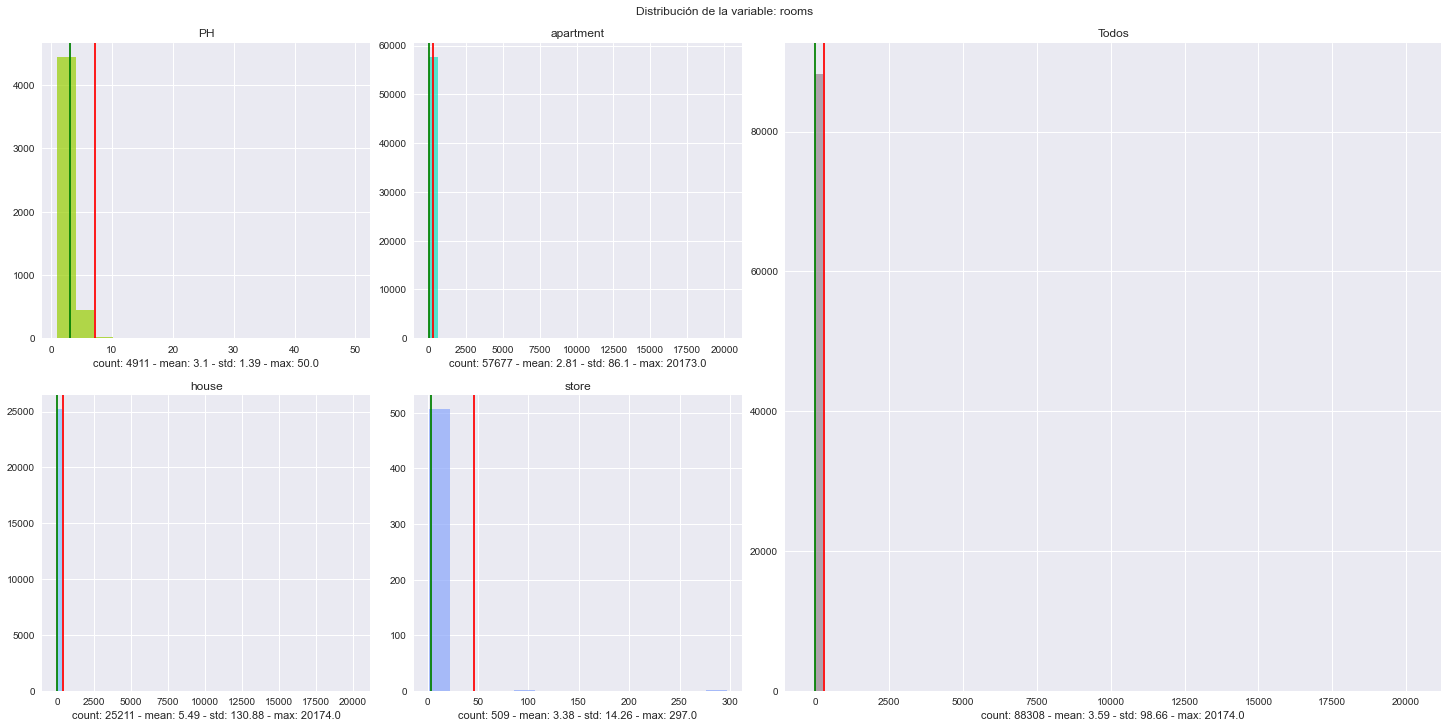

In [73]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: rooms")

histogram_plot_by_property_type(fig, o_data, 'rooms', non_na_bins = True, unique_bins = True)

plt.show()

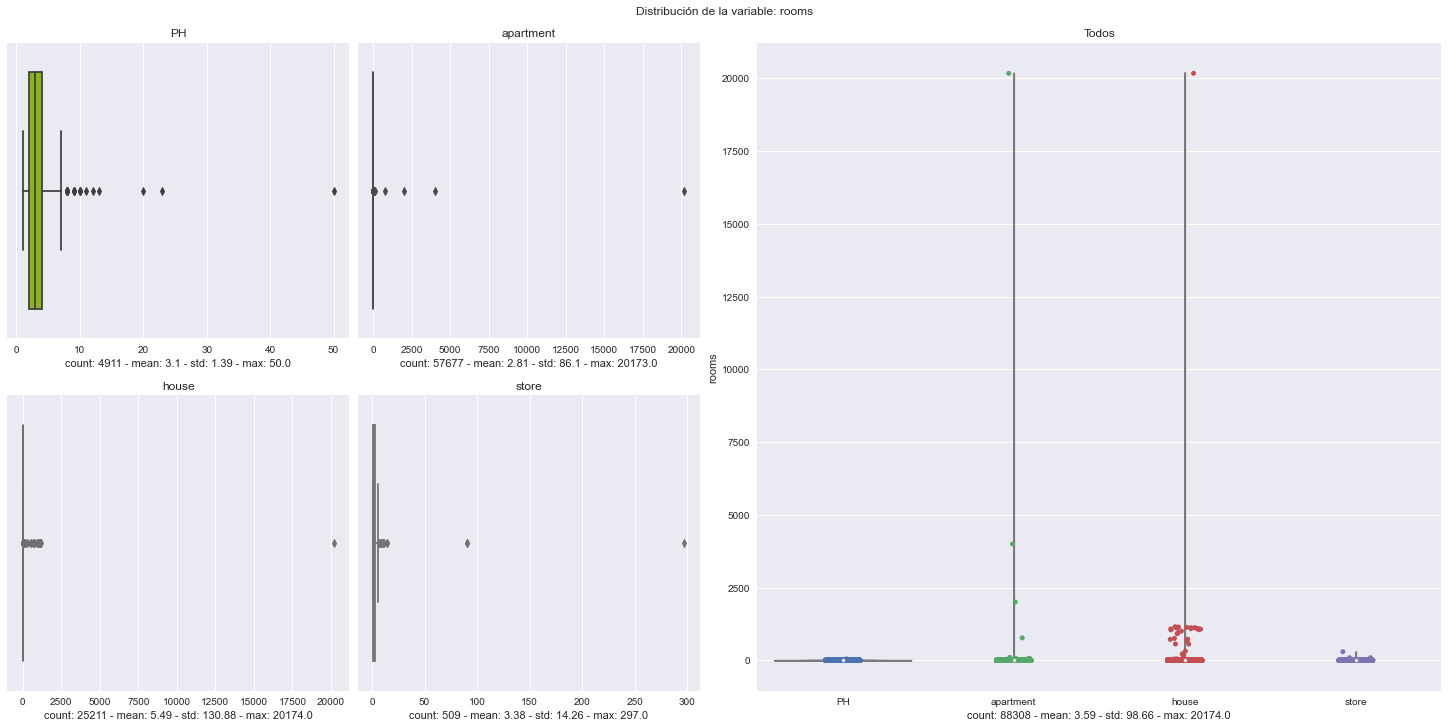

In [74]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: rooms")

box_plot_by_property_type(fig, o_data, 'rooms')

plt.show()

Se calcula el IQR para cada **property_type** teniendo en cuenta el mínimo lógico en `1`.

In [75]:
# calcula IQR para cada property_type.
q1 = o_data.groupby('property_type')['rooms'].quantile(q=0.25)
q3 = o_data.groupby('property_type')['rooms'].quantile(q=0.75)
iqr = q3 - q1
# el límite superior es libremente determinado por el iqr.
rooms_upper = q3 + 1.5 * iqr
# el límite inferior es determinado por el iqr aunque tiene un límite lógico en 1.
rooms_lower = (q1 - 1.5 * iqr).map(lambda x: 1 if x <= 0 else x)

In [76]:
describe_df(o_data.columns, o_data).loc['rooms']

Cardinality         73
Null             32912
% Null           27.15
Non-Null         88308
% Non-Null       72.85
Types          float64
Size (mb)         0.97
Name: rooms, dtype: object

In [77]:
o_data['rooms'] = o_data.apply(fill_na_by, args=['property_type', 'rooms', rooms_lower, rooms_upper], axis=1)

In [78]:
describe_df(o_data.columns, o_data).loc['rooms']

Cardinality          9
Null             33868
% Null           27.94
Non-Null         87352
% Non-Null       72.06
Types          float64
Size (mb)         0.97
Name: rooms, dtype: object

Mediante el proceso anterior, se quitaron 956 *outliers*.

La nueva distribución quedó conformada de la siguiente forma:

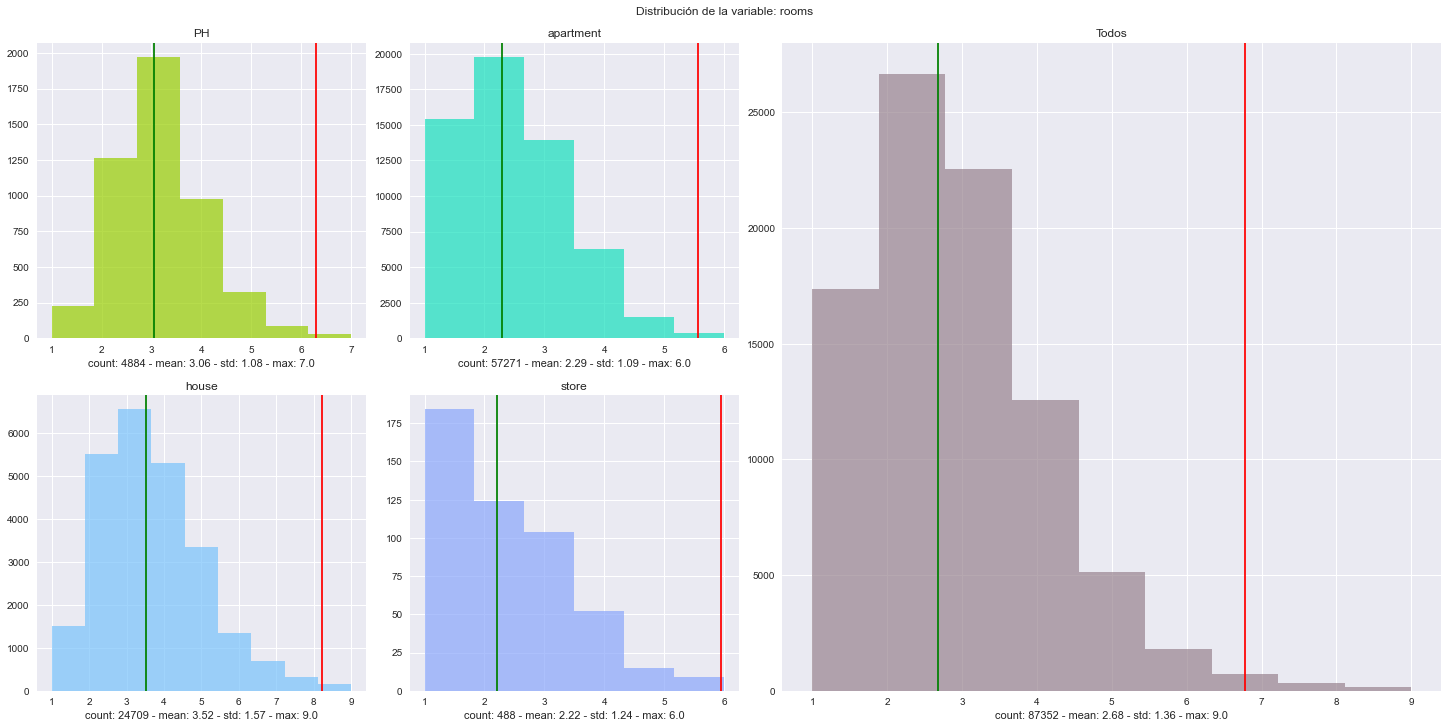

In [79]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: rooms")

histogram_plot_by_property_type(fig, o_data, 'rooms', non_na_bins = True, unique_bins = True)

plt.show()

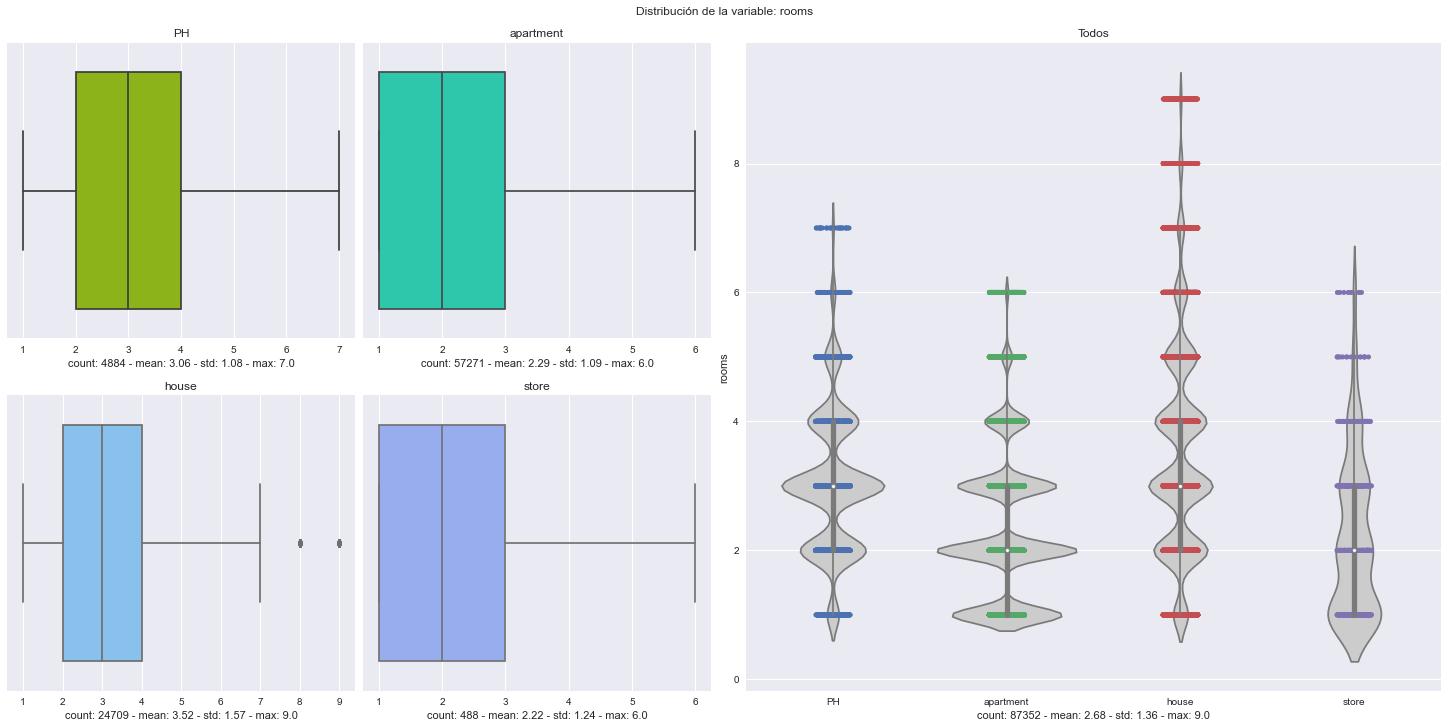

In [80]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: rooms")

box_plot_by_property_type(fig, o_data, 'rooms')

plt.show()

##### Outliers: price_aprox_usd

Se grafica la distribución de **price_aprox_usd** antes y después de la aplicación del filtrado. 

En este caso, los valores inferiores tienen un límite en 20.000 (para evitar negativos y valores irrisorios) mientras que los valores superiores del rango están determinados por el IQR.

In [81]:
q1 = o_data.groupby('property_type')['price_aprox_usd'].quantile(q=0.25)
q3 = o_data.groupby('property_type')['price_aprox_usd'].quantile(q=0.75)
iqr = q3 - q1
# la serie con el límite superior es estrictamente definida por el IQR.
price_upper = q3 + 1.5 * iqr
# la serie con el límite inferior se define en función de valores lógicos, debido a que el IQR incluye negativos.
price_lower = pd.Series({'PH': 20000, 'apartment': 20000, 'house': 20000, 'store': 20000})

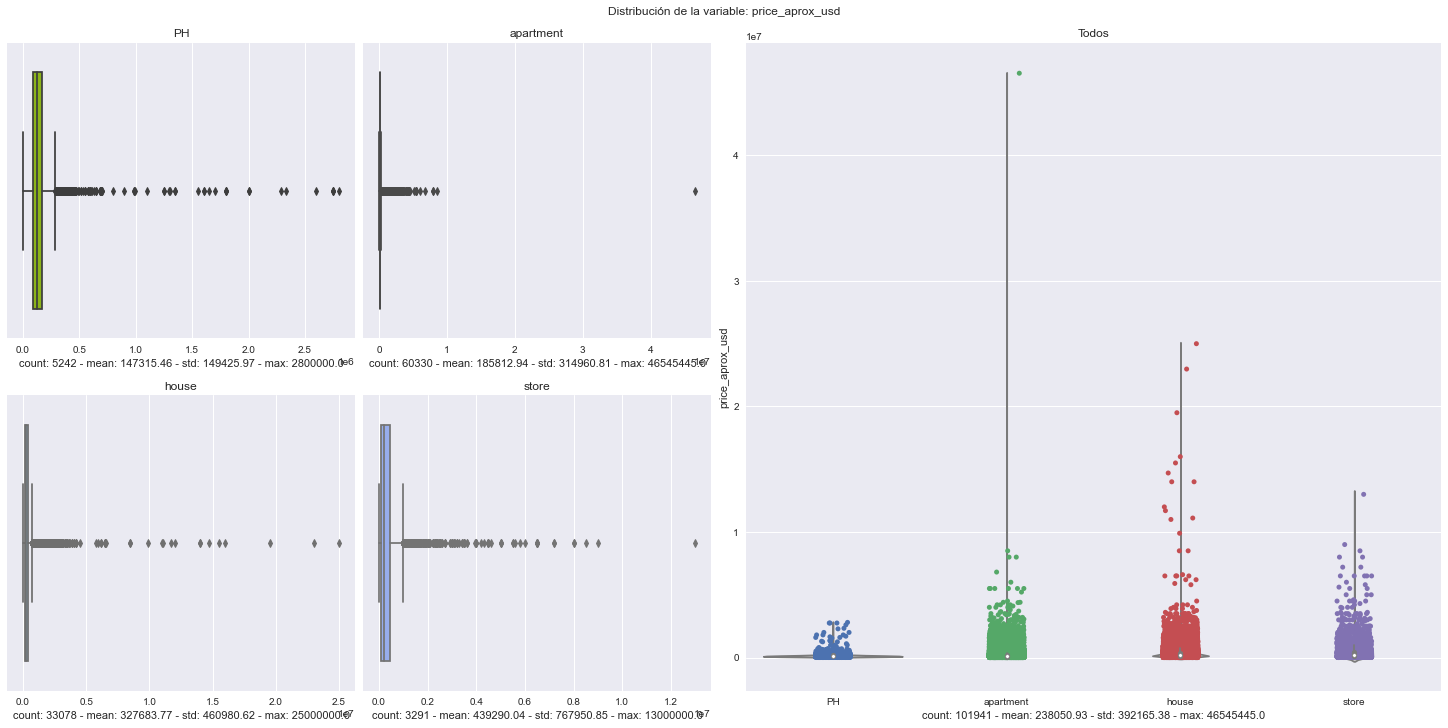

In [82]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_aprox_usd")

box_plot_by_property_type(fig, o_data, 'price_aprox_usd')

plt.show()

In [83]:
describe_df(o_data.columns, o_data).loc['price_aprox_usd']

Cardinality      10470
Null             19279
% Null           15.90
Non-Null        101941
% Non-Null       84.10
Types          float64
Size (mb)         0.97
Name: price_aprox_usd, dtype: object

In [84]:
o_data['price_aprox_usd'] = o_data.apply(fill_na_by, args=['property_type', 'price_aprox_usd', price_lower, price_upper], axis=1)

In [85]:
describe_df(o_data.columns, o_data).loc['price_aprox_usd']

Cardinality       8806
Null             29010
% Null           23.93
Non-Null         92210
% Non-Null       76.07
Types          float64
Size (mb)         0.97
Name: price_aprox_usd, dtype: object

Se reemplazaron 9731 *outliers*.

La nueva distribución de los datos de **price_aprox_usd** es la siguiente:

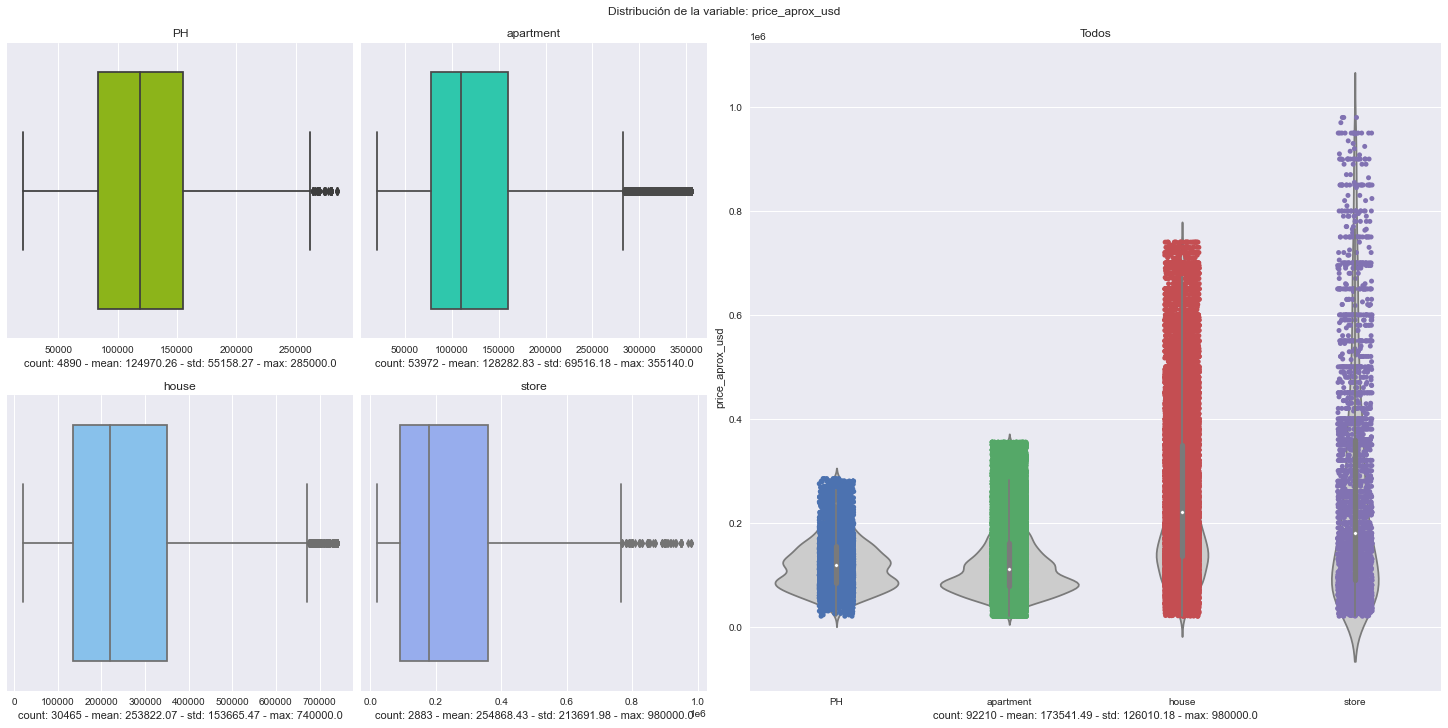

In [86]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_aprox_usd")

box_plot_by_property_type(fig, o_data, 'price_aprox_usd')

plt.show()

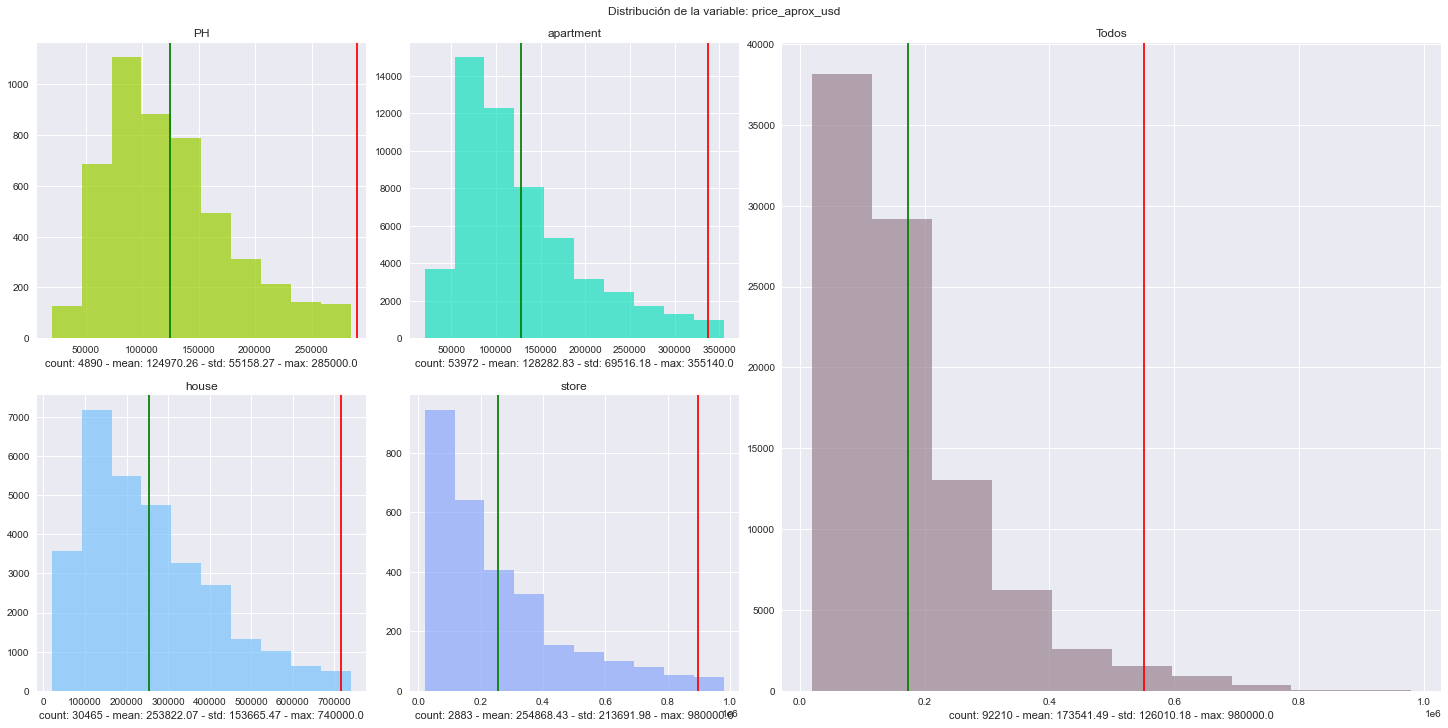

In [87]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_aprox_usd")

histogram_plot_by_property_type(fig, o_data, 'price_aprox_usd', non_na_bins = False, unique_bins = False)

plt.show()

##### Outliers: surface_total_in_m2

Se grafica la distribución de **surface_total_in_m2** antes y después de la aplicación del filtrado. 

En este caso, los valores inferiores tienen un límite en 10 (para evitar negativos y valores muy bajos) mientras que los valores superiores del rango están determinados por el IQR.

In [88]:
# calcula IQR para cada property_type.
q1 = o_data.groupby('property_type')['surface_total_in_m2'].quantile(q=0.25)
q3 = o_data.groupby('property_type')['surface_total_in_m2'].quantile(q=0.75)
iqr = q3 - q1
# el límite superior es libremente determinado por el iqr.
surface_total_upper = q3 + 1.5 * iqr
# el límite inferior es determinado por el iqr aunque tiene un límite lógico en 10.
surface_total_lower = (q1 - 1.5 * iqr).map(lambda x: 10 if x <= 0 else x)

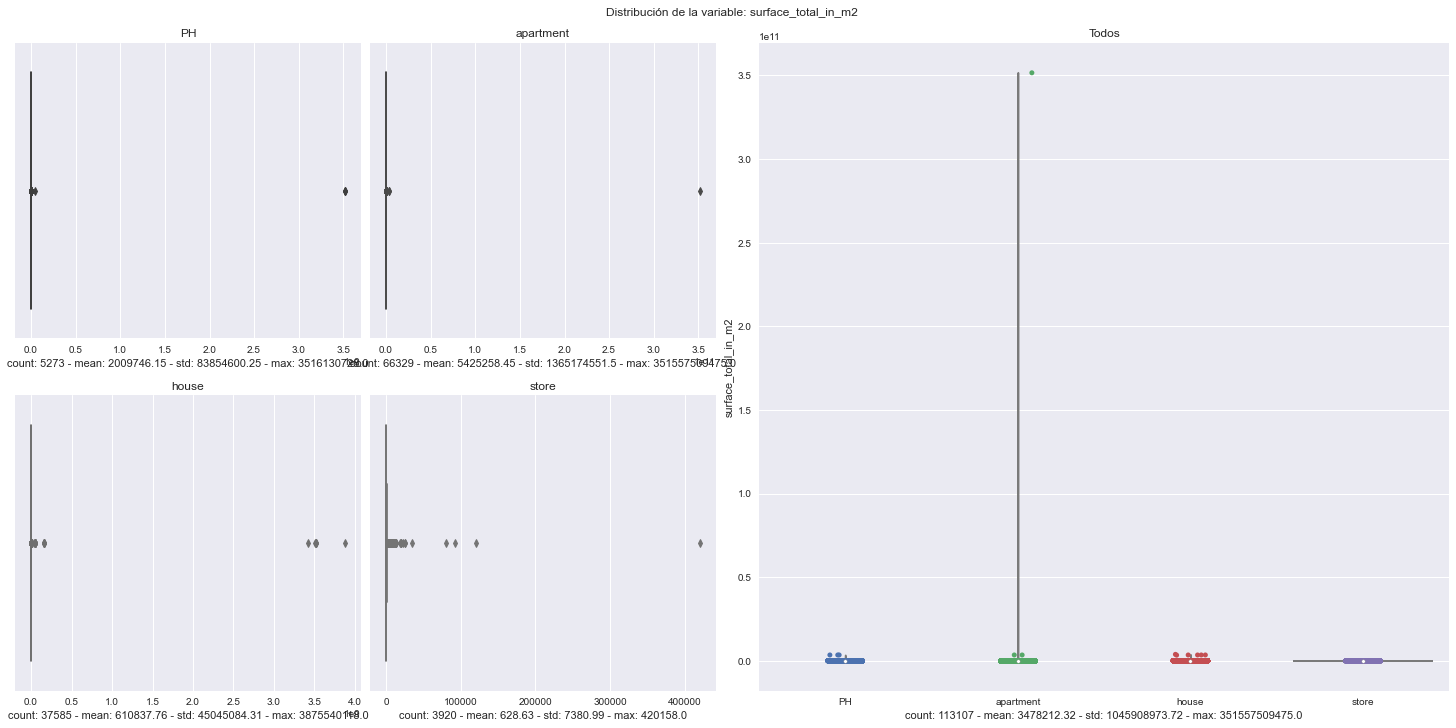

In [89]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_total_in_m2")

box_plot_by_property_type(fig, o_data, 'surface_total_in_m2')

plt.show()

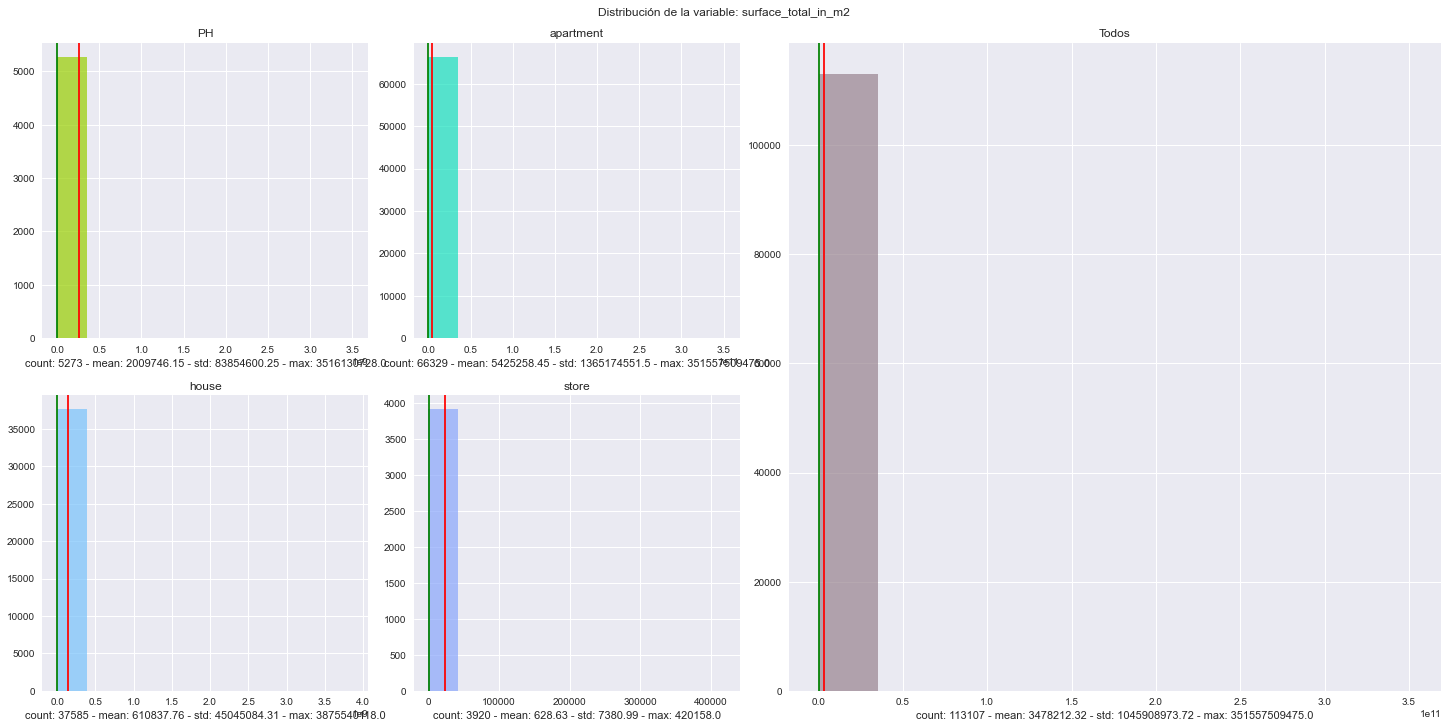

In [90]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_total_in_m2")

histogram_plot_by_property_type(fig, o_data, 'surface_total_in_m2', non_na_bins = False, unique_bins = False)

plt.show()

In [91]:
describe_df(o_data.columns, o_data).loc['surface_total_in_m2']

Cardinality       2272
Null              8113
% Null            6.69
Non-Null        113107
% Non-Null       93.31
Types          float64
Size (mb)         0.97
Name: surface_total_in_m2, dtype: object

In [92]:
o_data['surface_total_in_m2'] = o_data.apply(fill_na_by, args=['property_type', 'surface_total_in_m2', surface_total_lower, surface_total_upper], axis=1)

In [93]:
describe_df(o_data.columns, o_data).loc['surface_total_in_m2']

Cardinality       1046
Null             18796
% Null           15.51
Non-Null        102424
% Non-Null       84.49
Types          float64
Size (mb)         0.97
Name: surface_total_in_m2, dtype: object

Se removieron 10.683 *outliers*.

A continuación se grafica la nueva distribución de los datos para esta variable.

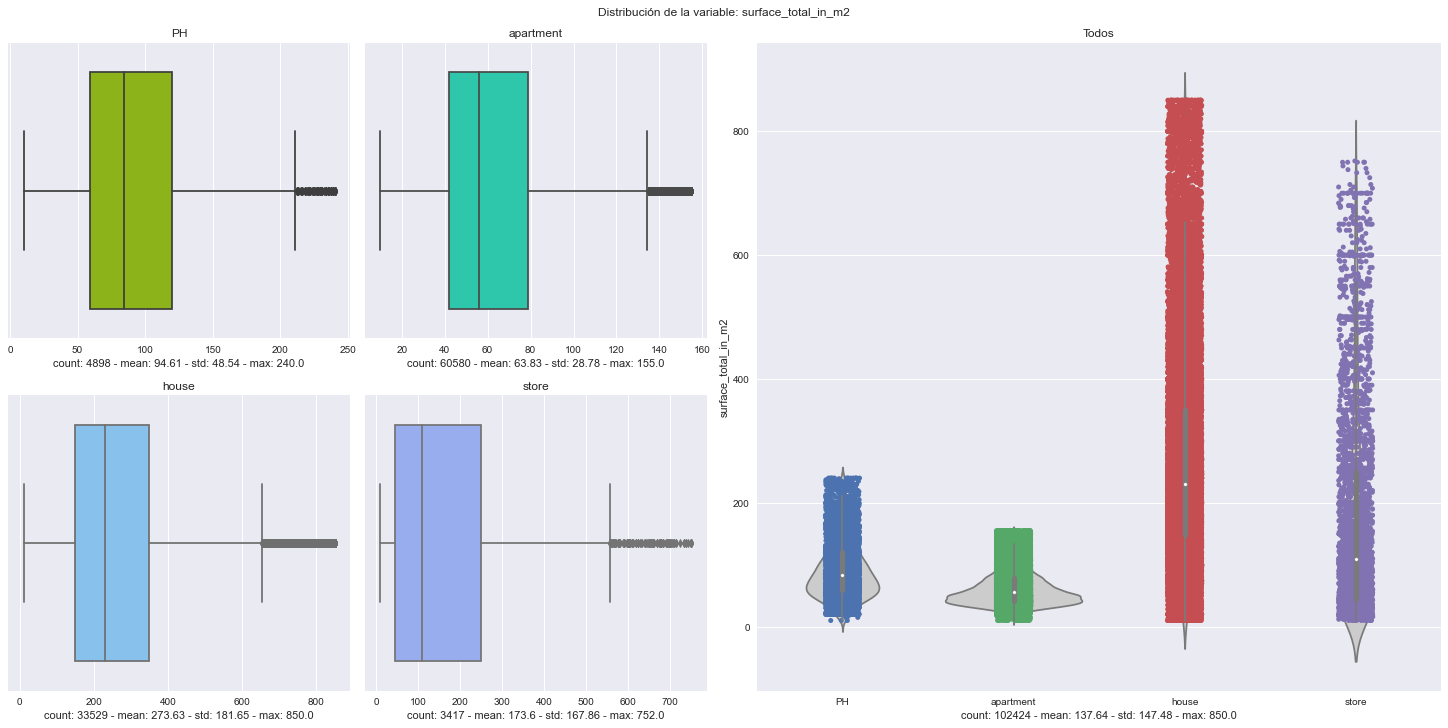

In [94]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_total_in_m2")

box_plot_by_property_type(fig, o_data, 'surface_total_in_m2')

plt.show()

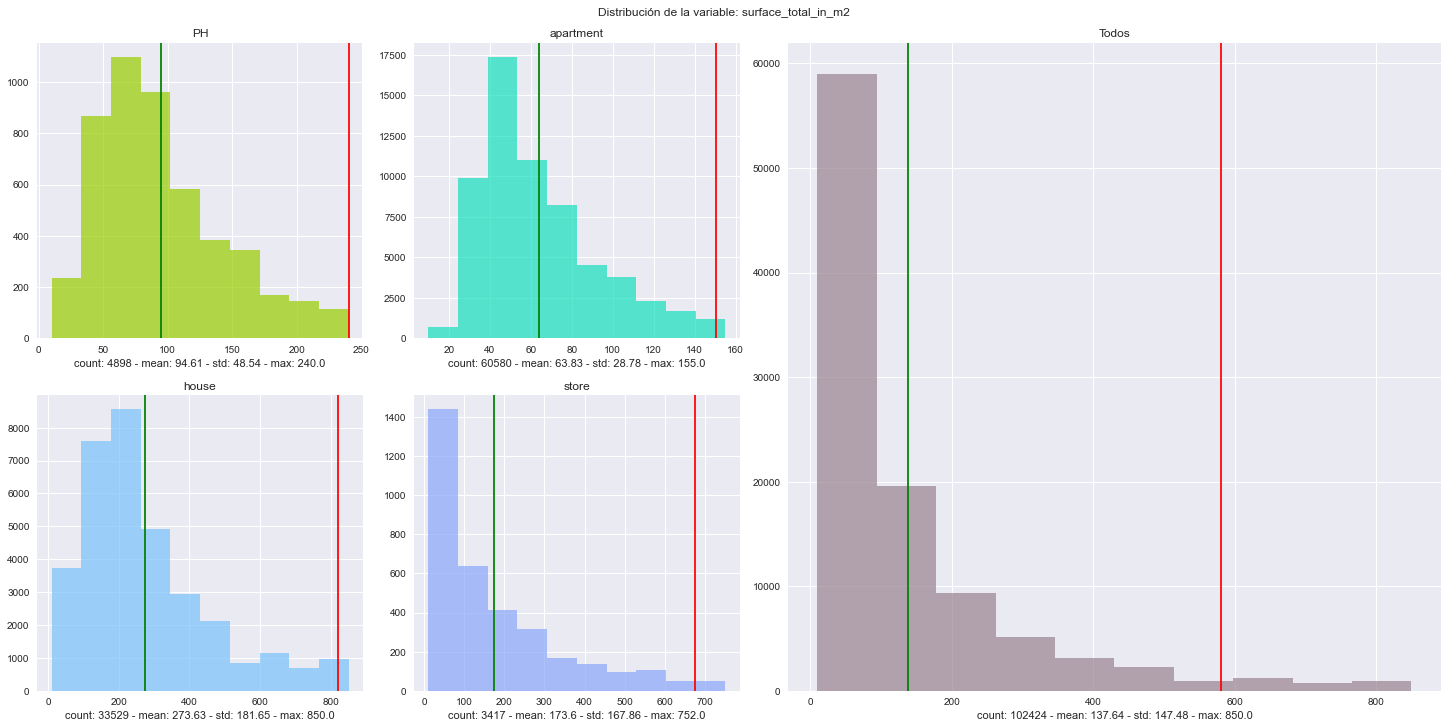

In [95]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_total_in_m2")

histogram_plot_by_property_type(fig, o_data, 'surface_total_in_m2', non_na_bins = False, unique_bins = False)

plt.show()

##### Outliers: surface_covered_in_m2

Se grafica la distribución de **surface_covered_in_m2** antes y después de la aplicación del filtrado. 

En este caso, los valores inferiores tienen un límite en 10 (para evitar negativos y valores muy bajos) mientras que los valores superiores del rango están determinados por el IQR.

In [96]:
# calcula IQR para cada property_type.
q1 = o_data.groupby('property_type')['surface_covered_in_m2'].quantile(q=0.25)
q3 = o_data.groupby('property_type')['surface_covered_in_m2'].quantile(q=0.75)
iqr = q3 - q1
# el límite superior es libremente determinado por el iqr.
surface_covered_upper = q3 + 1.5 * iqr
# el límite inferior es determinado por el iqr aunque tiene un límite lógico en 10.
surface_covered_lower = (q1 - 1.5 * iqr).map(lambda x: 10 if x <= 0 else x)

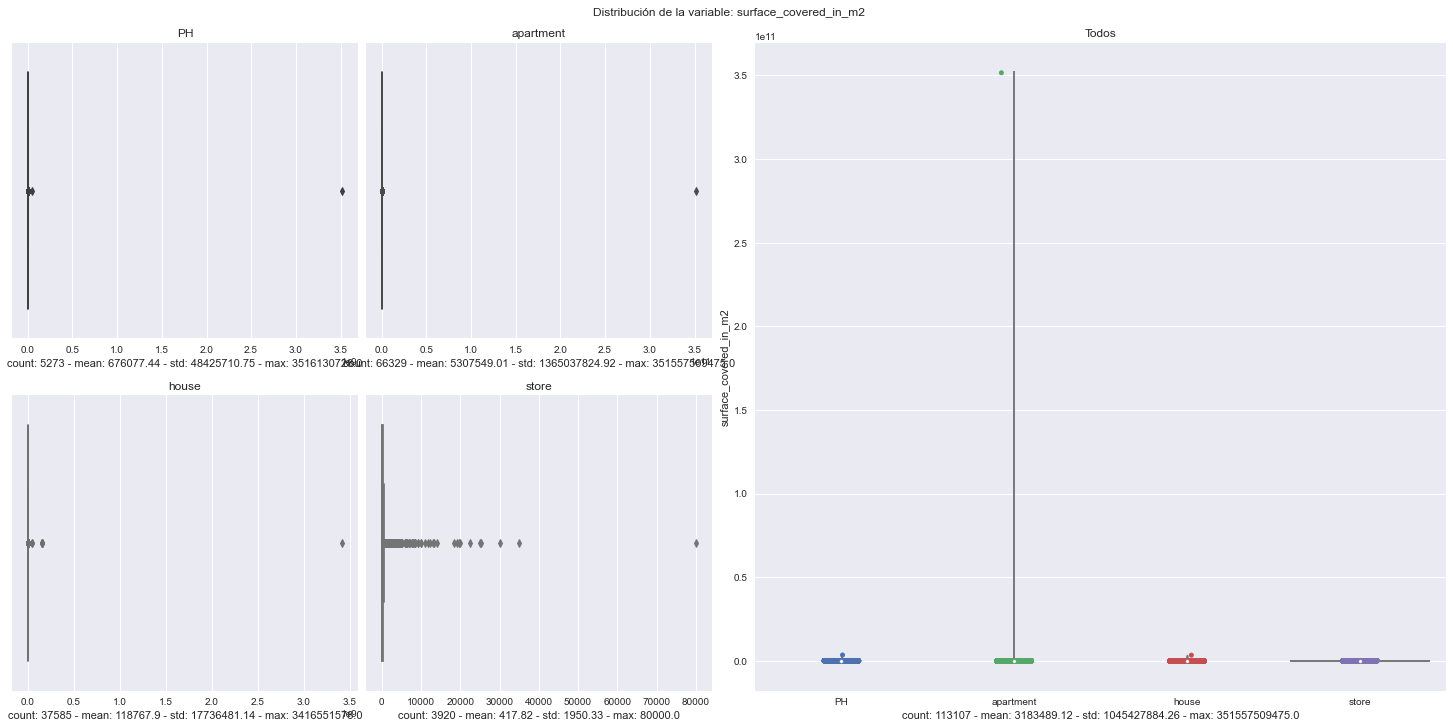

In [97]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_covered_in_m2")

box_plot_by_property_type(fig, o_data, 'surface_covered_in_m2')

plt.show()

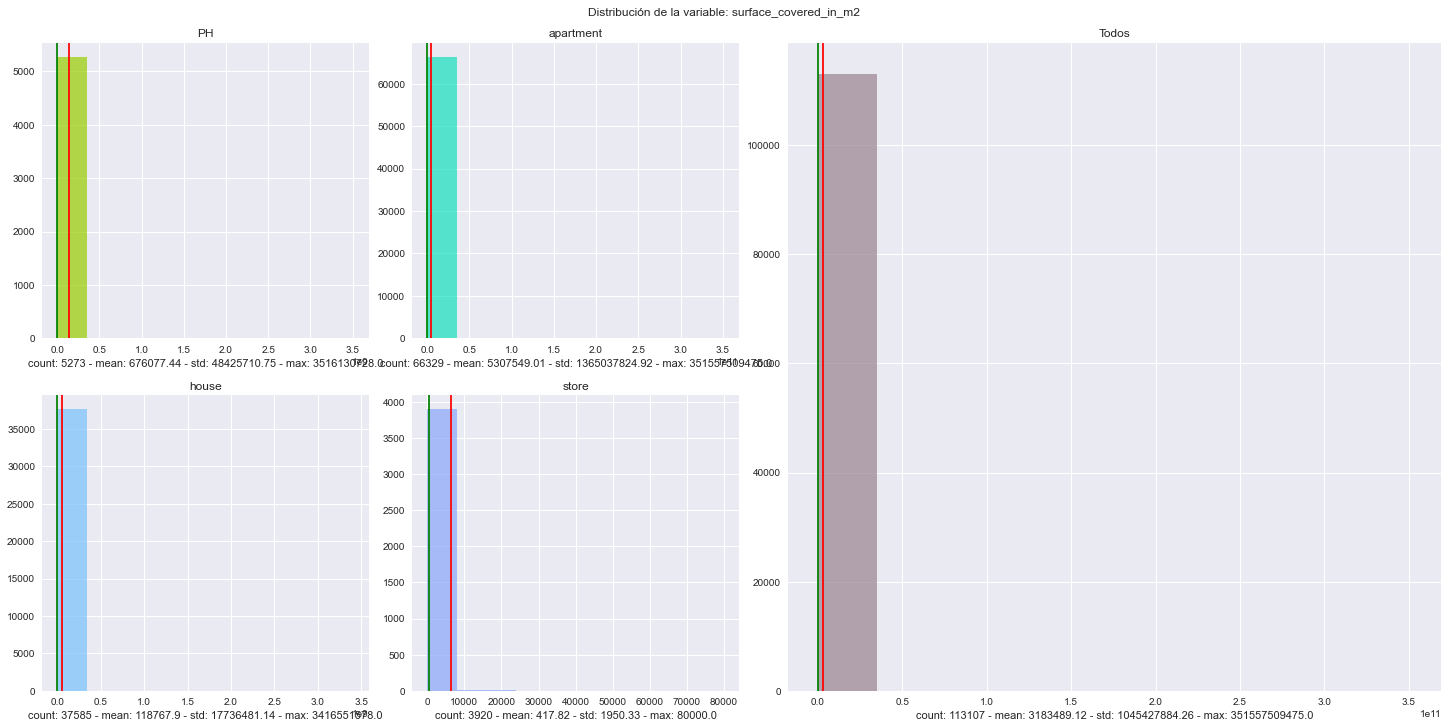

In [98]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_covered_in_m2")

histogram_plot_by_property_type(fig, o_data, 'surface_covered_in_m2', non_na_bins = False, unique_bins = False)

plt.show()

In [99]:
describe_df(o_data.columns, o_data).loc['surface_covered_in_m2']

Cardinality       1455
Null              8113
% Null            6.69
Non-Null        113107
% Non-Null       93.31
Types          float64
Size (mb)         0.97
Name: surface_covered_in_m2, dtype: object

In [100]:
o_data['surface_covered_in_m2'] = o_data.apply(fill_na_by, args=['property_type', 'surface_covered_in_m2', surface_covered_lower, surface_covered_upper], axis=1)

In [101]:
describe_df(o_data.columns, o_data).loc['surface_covered_in_m2']

Cardinality        669
Null             17169
% Null           14.16
Non-Null        104051
% Non-Null       85.84
Types          float64
Size (mb)         0.97
Name: surface_covered_in_m2, dtype: object

Se removieron 9056 *outliers*.

A continuación se grafica la nueva distribución de los datos para esta variable.

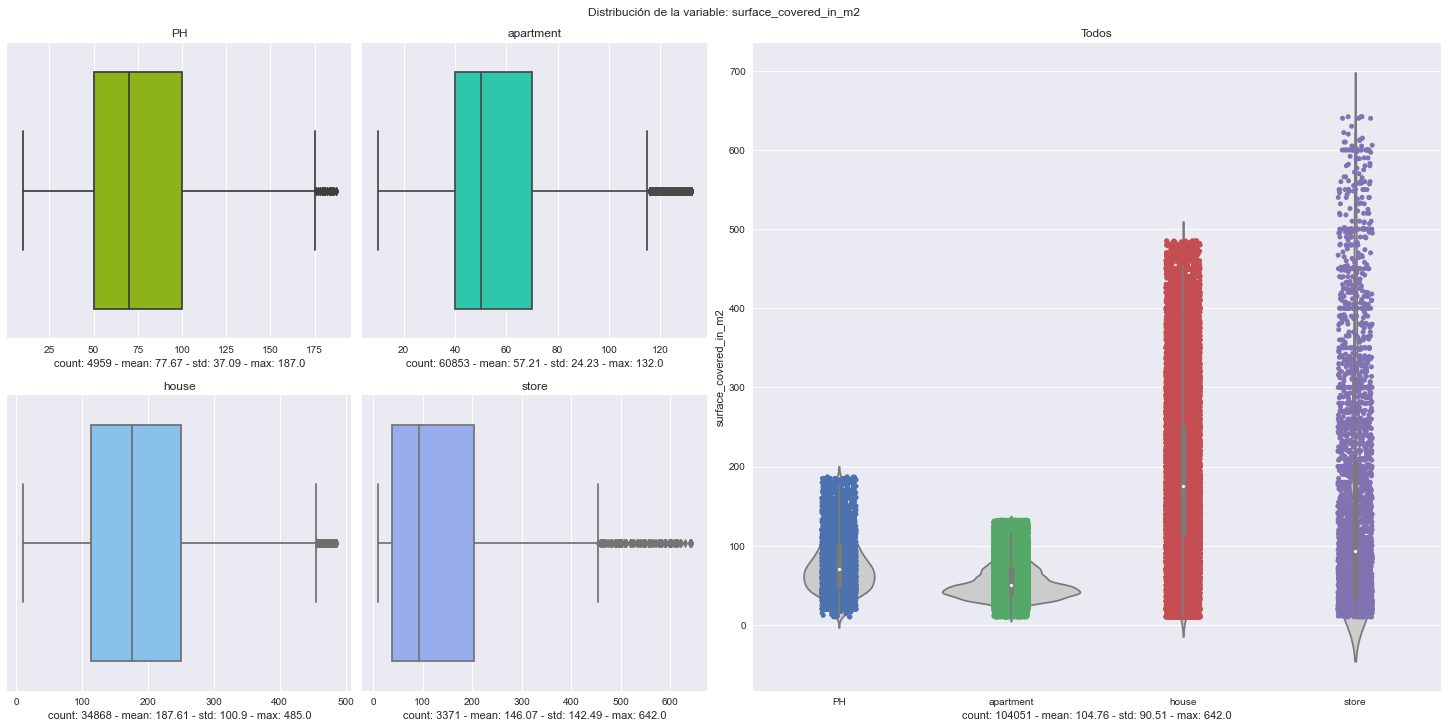

In [102]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_covered_in_m2")

box_plot_by_property_type(fig, o_data, 'surface_covered_in_m2')

plt.show()

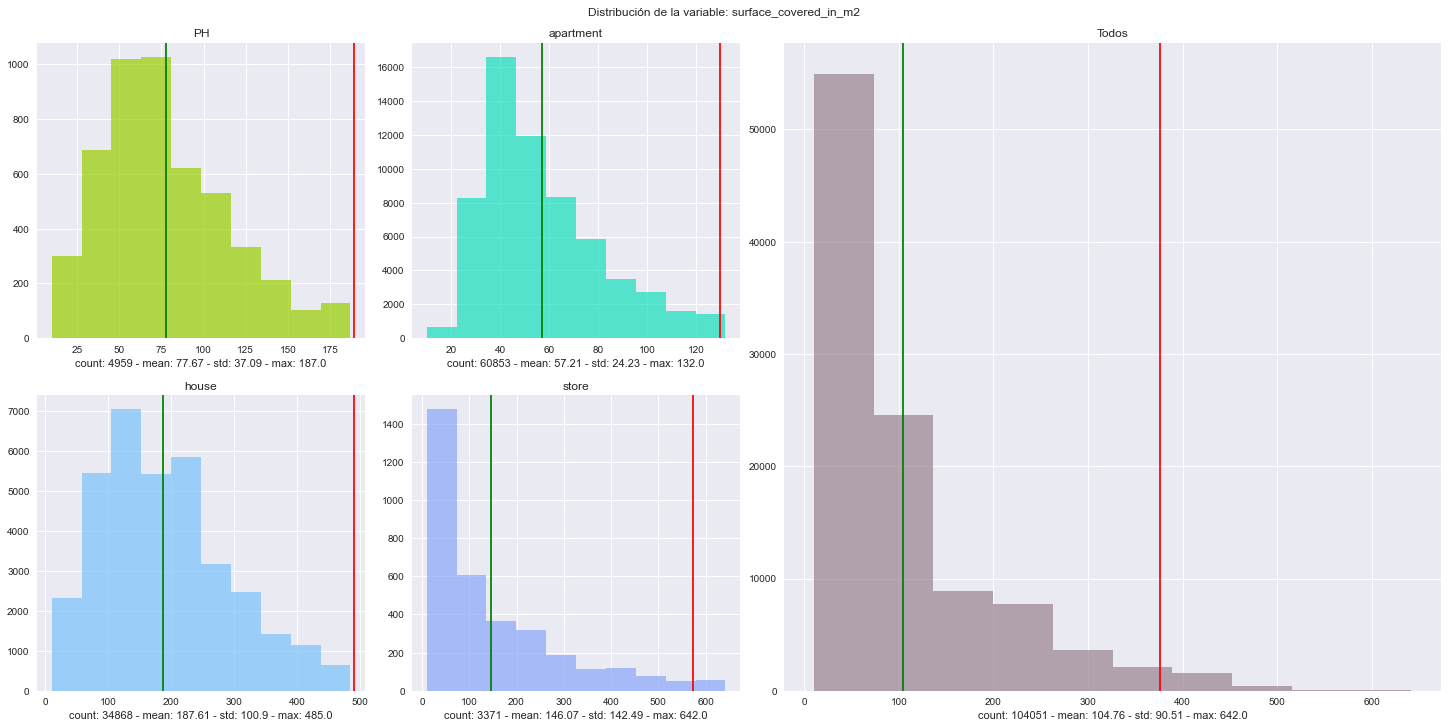

In [103]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: surface_covered_in_m2")

histogram_plot_by_property_type(fig, o_data, 'surface_covered_in_m2', non_na_bins = False, unique_bins = False)

plt.show()

##### Outliers: price_usd_per_m2

Se grafica la distribución de **price_usd_per_m2** antes y después de la aplicación del filtrado. 

En este caso, los valores inferiores tienen un límite en 100 (para evitar negativos y precios irrisorios) mientras que los valores superiores del rango están determinados por el IQR.

In [104]:
# calcula IQR para cada property_type.
q1 = o_data.groupby('property_type')['price_usd_per_m2'].quantile(q=0.25)
q3 = o_data.groupby('property_type')['price_usd_per_m2'].quantile(q=0.75)
iqr = q3 - q1
# el límite superior es libremente determinado por el iqr.
price_usd_per_m2_upper = q3 + 1.5 * iqr
# el límite inferior es determinado por el iqr aunque tiene un límite lógico en 10.
price_usd_per_m2_lower = (q1 - 1.5 * iqr).map(lambda x: 100 if x <= 0 else x)

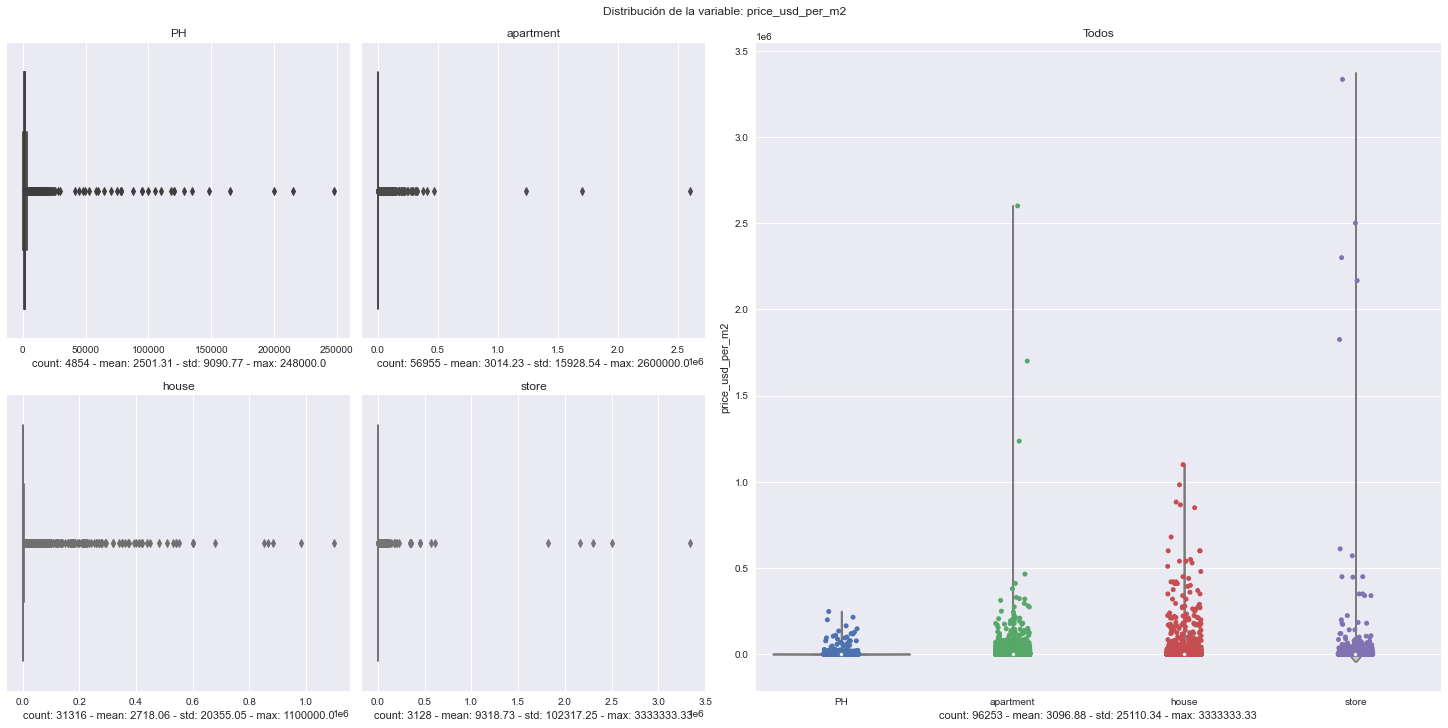

In [105]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_usd_per_m2")

box_plot_by_property_type(fig, o_data, 'price_usd_per_m2')

plt.show()

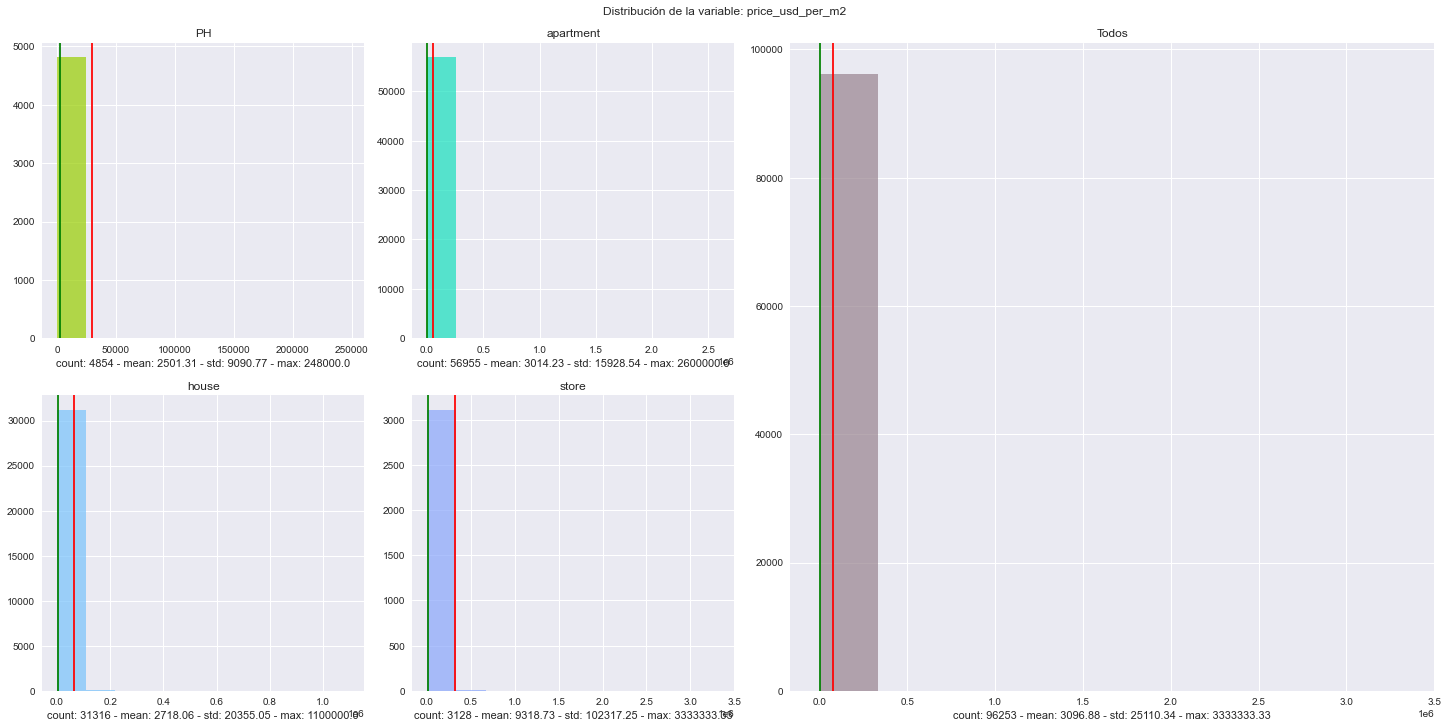

In [106]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_usd_per_m2")

histogram_plot_by_property_type(fig, o_data, 'price_usd_per_m2', non_na_bins = False, unique_bins = False)

plt.show()

In [107]:
describe_df(o_data.columns, o_data).loc['price_usd_per_m2']

Cardinality      32426
Null             24967
% Null           20.60
Non-Null         96253
% Non-Null       79.40
Types          float64
Size (mb)         0.97
Name: price_usd_per_m2, dtype: object

In [108]:
o_data['price_usd_per_m2'] = o_data.apply(fill_na_by, args=['property_type', 'price_usd_per_m2', price_usd_per_m2_lower, price_usd_per_m2_upper], axis=1)

In [109]:
describe_df(o_data.columns, o_data).loc['price_usd_per_m2']

Cardinality      28754
Null             31870
% Null           26.29
Non-Null         89350
% Non-Null       73.71
Types          float64
Size (mb)         0.97
Name: price_usd_per_m2, dtype: object

Se removieron 6.903 *outliers*.

A continuación se grafica la nueva distribución de los datos para esta variable.

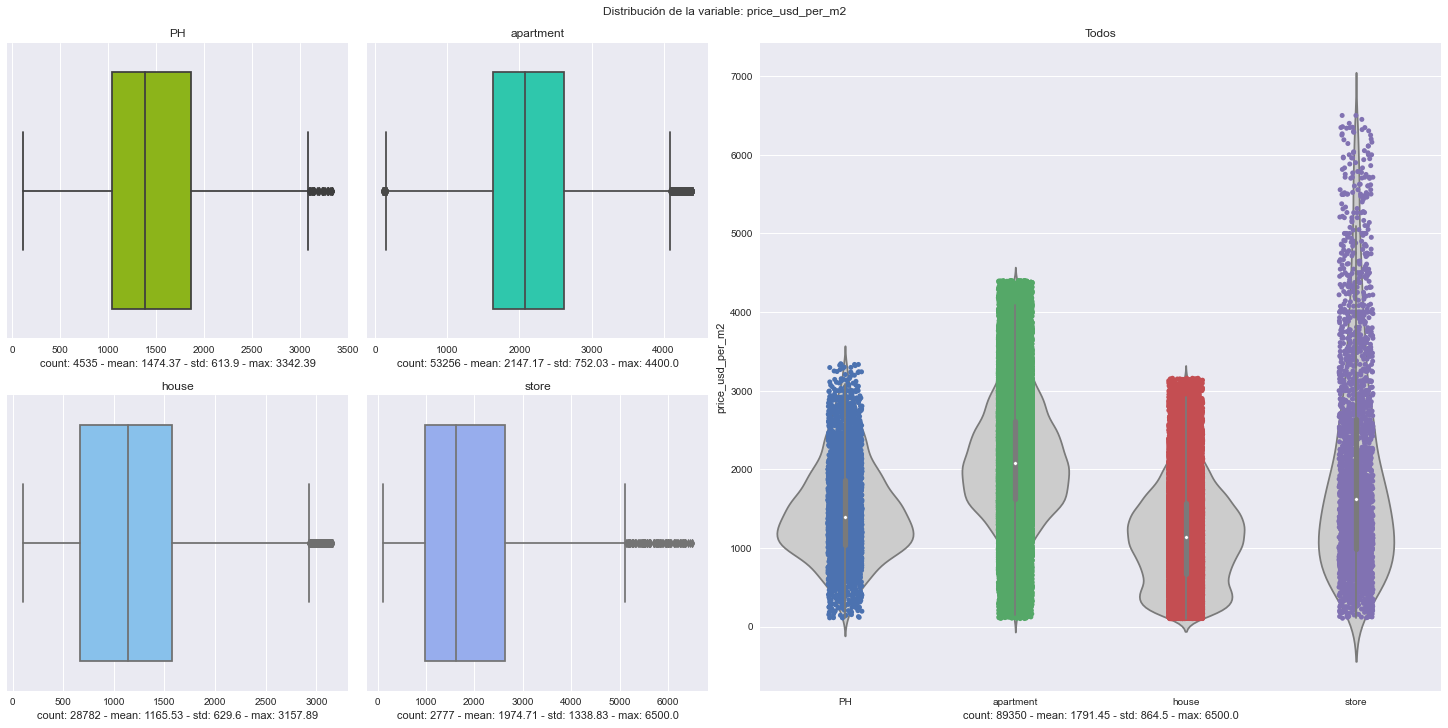

In [110]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_usd_per_m2")

box_plot_by_property_type(fig, o_data, 'price_usd_per_m2')

plt.show()

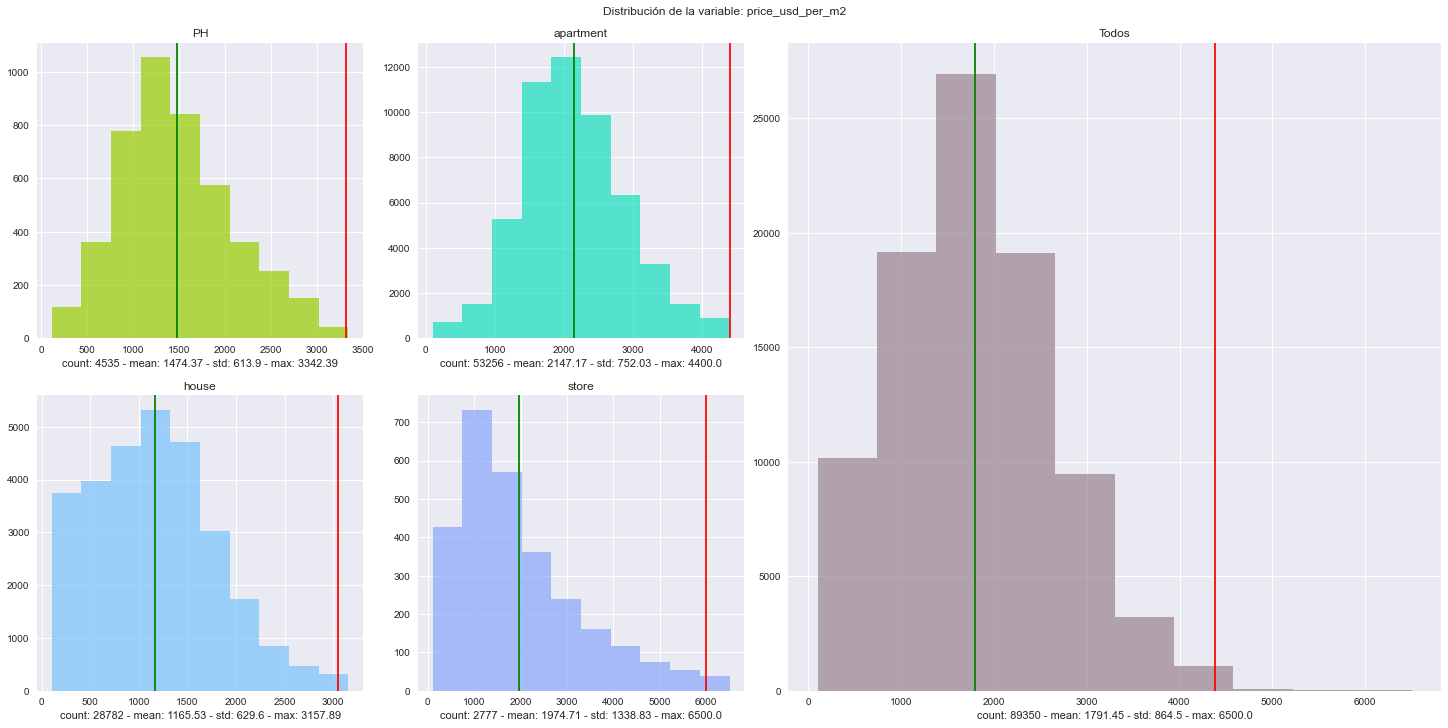

In [111]:
fig = plt.figure(constrained_layout=True, figsize=(20,10))

gs = GridSpec(2, 12, figure=fig)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:6])
ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, 3:6])
ax5 = fig.add_subplot(gs[:, 6:])

fig.suptitle("Distribución de la variable: price_usd_per_m2")

histogram_plot_by_property_type(fig, o_data, 'price_usd_per_m2', non_na_bins = False, unique_bins = False)

plt.show()

#### Análisis de nuevas features

A partir de los datos disponibles en el campo de texto **description**, se plantea agregar nuevas variables al `DataFrmae` para representar la existencia o inexistencia de ciertas características que ayudarían a la explicación y predicción del precio.

Estas nuevas variables son:
- has_amenities: para representar los casos donde existen servicios, instalaciones o ambientes que agregan un valor por encima de los ambientes convencionales.
- is_new: para representar las propiedades a estrenar.
- is_outlier: para identificar propiedades que no son útiles a la estimación.
- has_front: para representar a las casas con frente.

En todos los casos se aplica la técnica de `regex` para obtener los valores.

In [115]:
def buscar_patron(pattern, data, nombre_columna):
    pattern_regex = re.compile(pattern)
    pattern_series = data.description.astype(str)
    result_pattern = pattern_series.apply(lambda x: pattern_regex.search(x))    
    data[nombre_columna] = result_pattern.apply(lambda x: 0.0 if x is None else 1.0)

# Sum/Parrilla/Balcon/garage/lavadero/balcon/parrilla/piscina/quincho/sum/dependencias/amenities/baulera/hidromasaje/amoblado/sauna/tenis/sotano
pattern_amenities = "(?i)sum|pileta|parrilla|seguridad|gym|gim|gimnasio|balcon|dependencias|hidromasajes|sauna|tenis|tennis|amoblado|baulera"
nombre_columna="has_amenities"
buscar_patron(pattern_amenities, o_data, nombre_columna)

# Nuevo
pattern_nuevo = "(?i)nuevo|estrenar|new|nueva"
nombre_columna="is_new"
buscar_patron(pattern_nuevo, o_data, nombre_columna)

# Outliers: Galpón
pattern_galpon = "(?i)galpon"
nombre_columna="is_outlier"
buscar_patron(pattern_galpon, o_data, nombre_columna)

# Frente/Pulmón
pattern_frente = "(?i)frente"
nombre_columna="has_front"
buscar_patron(pattern_frente, o_data, nombre_columna)

In [116]:
describe_df(o_data.columns, o_data)

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
Unnamed: 0,121220,0,0.00,121220,100.00,int64,0.97
operation,1,0,0.00,121220,100.00,object,0.97
property_type,4,0,0.00,121220,100.00,object,0.97
place_name,1060,0,0.00,121220,100.00,object,0.97
place_with_parent_names,1164,0,0.00,121220,100.00,object,0.97
country_name,1,0,0.00,121220,100.00,object,0.97
state_name,28,0,0.00,121220,100.00,object,0.97
geonames_id,646,18717,15.44,102503,84.56,float64,0.97
lat-lon,47203,51550,42.53,69670,57.47,object,0.97
lat,46918,60,0.05,121160,99.95,float64,0.97


#### Filtrado de campos nulos y columnas no relevantes

Se define a la variable `f_data` como aquella que contendrá a la versión final del `DataFrame` con los datos originales ya limpios.

Finalmente, las variables que formarán parte del juego de datos final son las siguientes:

- property_type
- state_name
- place_name
- lat
- lon
- price_aprox_usd
- surface_total_in_m2
- surface_covered_in_m2
- price_usd_per_m2
- rooms
- has_amenities
- is_new

In [117]:
f_data = o_data[['property_type', 'state_name', 'place_name', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'rooms', 'has_amenities', 'is_new']]

In [118]:
describe_df(f_data.columns, f_data)

,Cardinality,Null,% Null,Non-Null,% Non-Null,Types,Size (mb)
property_type,4,0,0.00,121220,100.00,object,0.97
state_name,28,0,0.00,121220,100.00,object,0.97
place_name,1060,0,0.00,121220,100.00,object,0.97
lat,46918,60,0.05,121160,99.95,float64,0.97
lon,46942,60,0.05,121160,99.95,float64,0.97
price_aprox_usd,8806,29010,23.93,92210,76.07,float64,0.97
surface_total_in_m2,1046,18796,15.51,102424,84.49,float64,0.97
surface_covered_in_m2,669,17169,14.16,104051,85.84,float64,0.97
price_usd_per_m2,28754,31870,26.29,89350,73.71,float64,0.97
rooms,9,33868,27.94,87352,72.06,float64,0.97


In [121]:
price_mask = f_data['price_aprox_usd'].notnull()
surface_total_mask = f_data['surface_total_in_m2'].notnull()
price_usd_per_m2_mask = f_data['price_usd_per_m2'].notnull()

In [125]:
f_data.loc[ price_mask & price_usd_per_m2_mask ].shape[0] / o_data.shape[0]

0.6888714733542319